# Take Home Assessment - Part 1 - Classification Model - Gauravi Patankar (gsp2137@columbia.edu)

## Problem Definition
The goal is to predict whether a person will have an income of less than or greater than \$50,000

##### The purpose of this classification is for targeted marketing:
- High-income individuals may respond to premium product promotions
- low-income groups might prefer value discounts


- Since it's not explicitly stated which income segment (high or low) should be prioritized, the classification model's goal is to perform well across both classes.
- For this, the evaluation metric should balance precision and recall.
- Therefore, I’ll primarily use the ***F1-score*** as the key metric, while also monitoring Precision and Recall for a complete view of model performance.

In a marketing context:
- High precision would mean fewer false-positives --> ideal if the goal is to target verified high-income customers
- High recall would mean we capture most potential high-income customers, even at the cost of some false alarms.

### Importing Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from scipy.stats import chi2_contingency, spearmanr, pearsonr
from sklearn.metrics import mutual_info_score
from itertools import combinations

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)

import warnings
warnings.filterwarnings("ignore")

### Data

- The dataset contains 40 demographic and employment-related variables for each individual, drawn from the 1994–1995 U.S. Census Current Population Survey.
- Each observation also includes a sampling **weight**, indicating how many people in the population the record represents

In [2]:
# Reading column names
with open("census-bureau.columns") as f:
    columns = [line.strip() for line in f.readlines()]

# Reading data
df = pd.read_csv("census-bureau.data", names=columns, header=None)

In [3]:
# Viewing data
print(df.shape)
df.head(10)

(199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

### Target Variable Analysis

The target variable (`label`) is imbalanced. Only 6% of the people belong to the high income segment.
Because of this imbalance, accuracy is a misleading evaluation metric. This also suggests that focus should be on ***precision, recall, and the F1-score***.

In [5]:
# Check unique class distribution
df['label'].value_counts()

# Check percentage distribution
df['label'].value_counts(normalize=True) * 100

label
- 50000.    93.794199
50000+.      6.205801
Name: proportion, dtype: float64

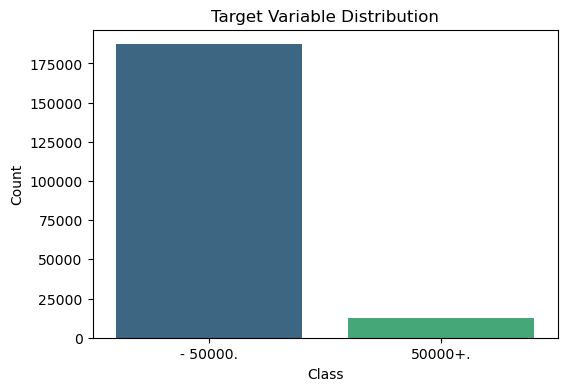

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Data Cleaning

#### 1. Handling Duplicates

- Found 3,229 identical records out of 199,523 (about 1.6%).
- Since it's census data, these could represent real individuals with identical demographic profiles rather than true data-entry errors, removing them would slightly alter the population distribution.
- Additionally, given the small proportion, for simplicity, I decided to keep them to preserve population integrity.

In [7]:
df.duplicated().sum()

np.int64(3229)

In [8]:
df[df.duplicated()].shape

(3229, 42)

In [9]:
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(constant_cols)

[]


No constant value columns in the data.

#### 2. Fixing Data Types

- The year column was converted to category dtype since it only contains two unique values (1994 and 1995) representing survey years.
- Next, the `detailed industry recode` and `detailed occupation recode` columns were also changed to categories since these are actually codes describing employment context.
-  `veterans benefits` and `own business or self employed` columns were also converted to category, as these indicate discrete, unique values (0, 1, and 2)

In [10]:
df = df.astype({col: 'category' for col in df.select_dtypes(include='object').columns})

In [11]:
# there are only two years (1994 and 1995)
df['year'] = df['year'].astype('category')

# categorical codes describing employment context
df['detailed industry recode'] = df['detailed industry recode'].astype('category')
df['detailed occupation recode'] = df['detailed occupation recode'].astype('category')

# categorical cols
df['veterans benefits'] = df['veterans benefits'].astype('category')
df['own business or self employed'] = df['own business or self employed'].astype('category')

##### Bucketing/Binning High Cardinality Data

Finally, I reorganized and consolidated categories within several high-cardinality variables, specifically, `education`, `country of birth father`, `country of birth mother`, `country of birth self`, and `detailed household and family stat`.

In [12]:
# Count categories for each categorical column
cat_cols = df.select_dtypes(include=["category"]).columns.tolist()

cardinality = (
    df[cat_cols]
    .apply(lambda s: s.astype("category").cat.categories.size)
    .sort_values(ascending=False)
    .rename("n_unique")
    .to_frame()
)

display(cardinality)
print(f"Total categorical columns: {len(cat_cols)}")

,n_unique
detailed industry recode,52
state of previous residence,51
detailed occupation recode,47
country of birth self,43
country of birth mother,43
country of birth father,43
detailed household and family stat,38
major industry code,24
education,17
major occupation code,15


Total categorical columns: 34


In [13]:
# education
df['education'] = df['education'].astype(str).str.strip().str.lower()
edu_group_map = {
    'less than 1st grade': 'Below High School',
    '1st 2nd 3rd or 4th grade': 'Below High School',
    '5th or 6th grade': 'Below High School',
    '7th and 8th grade': 'Below High School',
    '9th grade': 'Below High School',
    '10th grade': 'Below High School',
    '11th grade': 'Below High School',
    '12th grade no diploma': 'Below High School',
    'high school graduate': 'High School Graduate',
    'some college but no degree': 'Some College',
    'associates degree-occup /vocational': 'Associate Degree',
    'associates degree-academic program': 'Associate Degree',
    'bachelors degree(ba ab bs)': 'Bachelors Degree',
    'masters degree(ma ms meng med msw mba)': 'Graduate/Professional Degree',
    'prof school degree (md dds dvm llb jd)': 'Graduate/Professional Degree',
    'doctorate degree(phd edd)': 'Graduate/Professional Degree',
    'children': 'Children'
}
df['education'] = df['education'].map(edu_group_map)
df['education'] = df['education'].astype('category')

df['education'].value_counts(dropna=False)

education
High School Graduate            48407
Children                        47422
Below High School               36691
Some College                    27820
Bachelors Degree                19865
Associate Degree                 9721
Graduate/Professional Degree     9597
Name: count, dtype: int64

In [14]:
# detailed household and family stat

df['detailed household and family stat'] = (df['detailed household and family stat']
    .astype(str).str.strip().str.lower()
)
household_group_map = {
    # Householder
    'householder': 'Householder',
    'nonfamily householder': 'Householder',

    # Spouse/Partner
    'spouse of householder': 'Spouse/Partner',
    'spouse of rp of unrelated subfamily': 'Spouse/Partner',

    # Child
    'child <18 never marr not in subfamily': 'Child',
    'child 18+ never marr not in a subfamily': 'Child',
    'child 18+ ever marr not in a subfamily': 'Child',
    'child <18 ever marr not in subfamily': 'Child',
    'child 18+ spouse of subfamily rp': 'Child',
    'child <18 spouse of subfamily rp': 'Child',
    'child 18+ never marr rp of subfamily': 'Child',
    'child <18 never marr rp of subfamily': 'Child',
    'child 18+ ever marr rp of subfamily': 'Child',
    'child <18 ever marr rp of subfamily': 'Child',
    'child under 18 of rp of unrel subfamily': 'Child',

    # Grandchild
    'grandchild <18 never marr not in subfamily': 'Grandchild',
    'grandchild <18 ever marr not in subfamily': 'Grandchild',
    'grandchild 18+ never marr not in subfamily': 'Grandchild',
    'grandchild 18+ ever marr not in subfamily': 'Grandchild',
    'grandchild 18+ spouse of subfamily rp': 'Grandchild',
    'grandchild <18 never marr rp of subfamily': 'Grandchild',
    'grandchild <18 ever marr rp of subfamily': 'Grandchild',
    'grandchild 18+ ever marr rp of subfamily': 'Grandchild',
    'grandchild 18+ never marr rp of subfamily': 'Grandchild',
    'grandchild <18 never marr child of subfamily rp': 'Grandchild',

    # Other Relative
    'other rel 18+ ever marr not in subfamily': 'Other Relative',
    'other rel 18+ never marr not in subfamily': 'Other Relative',
    'other rel <18 never marr not in subfamily': 'Other Relative',
    'other rel <18 ever marr not in subfamily': 'Other Relative',
    'other rel 18+ spouse of subfamily rp': 'Other Relative',
    'other rel <18 spouse of subfamily rp': 'Other Relative',
    'other rel 18+ ever marr rp of subfamily': 'Other Relative',
    'other rel 18+ never marr rp of subfamily': 'Other Relative',
    'other rel <18 ever marr rp of subfamily': 'Other Relative',
    'other rel <18 never married rp of subfamily': 'Other Relative',
    'other rel <18 never marr child of subfamily rp': 'Other Relative',
    'other rel 18+ spouse of subfamily rp': 'Other Relative',
    'other rel 18+ ever marr rp of subfamily': 'Other Relative',

    # Non-relative/Secondary
    'secondary individual': 'Non-relative/Secondary',
    'rp of unrelated subfamily': 'Non-relative/Secondary',

    # Group quarters
    'in group quarters': 'Group Quarters'
}

df['detailed household and family stat'] = (
    df['detailed household and family stat']
    .map(household_group_map)
    .fillna('Other')
    .astype('category')
)

df['detailed household and family stat'].value_counts(dropna=False)

detailed household and family stat
Householder               75461
Child                     65614
Spouse/Partner            41747
Non-relative/Secondary     6807
Other Relative             6326
Grandchild                 3372
Group Quarters              196
Name: count, dtype: int64

In [15]:
# country
cols = ['country of birth father', 'country of birth mother', 'country of birth self']
region_map = {
    # --- North America ---
    'United-States': 'North America',
    'Canada': 'North America',

    # --- Latin America / Caribbean ---
    'Mexico': 'Latin America',
    'Puerto-Rico': 'Latin America',
    'Cuba': 'Latin America',
    'Dominican-Republic': 'Latin America',
    'Jamaica': 'Latin America',
    'Honduras': 'Latin America',
    'El-Salvador': 'Latin America',
    'Guatemala': 'Latin America',
    'Colombia': 'Latin America',
    'Ecuador': 'Latin America',
    'Peru': 'Latin America',
    'Nicaragua': 'Latin America',
    'Trinadad&Tobago': 'Latin America',
    'Haiti': 'Latin America',

    # --- Europe ---
    'England': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Ireland': 'Europe',
    'Scotland': 'Europe',
    'Greece': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',

    # --- Asia ---
    'China': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'Philippines': 'Asia',
    'Vietnam': 'Asia',
    'Korea': 'Asia',
    'Cambodia': 'Asia',
    'Laos': 'Asia',
    'Thailand': 'Asia',
    'Taiwan': 'Asia',
    'Hong-Kong': 'Asia',

    # --- Middle East / Other ---
    'Iran': 'Middle East',
    'Israel': 'Middle East',
}

for col in cols:
    df[col] = df[col].map(region_map).fillna('Other')
    df[col] = df[col].astype('category')

for col in cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


country of birth father value counts:
country of birth father
North America    160543
Latin America     18680
Other              8147
Europe             7825
Asia               4095
Middle East         233
Name: count, dtype: int64

country of birth mother value counts:
country of birth mother
North America    161930
Latin America     18171
Other              7636
Europe             7417
Asia               4171
Middle East         198
Name: count, dtype: int64

country of birth self value counts:
country of birth self
North America    177689
Latin America     11229
Other              4545
Asia               2975
Europe             2928
Middle East         157
Name: count, dtype: int64


#### 3. Missing Value Check

In [16]:
df[df.columns[df.isnull().any()]].isnull().sum()

hispanic origin    874
dtype: int64

In [17]:
df['hispanic origin'].value_counts(dropna=False)

hispanic origin
All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
NaN                             874
Do not know                     306
Chicano                         304
Name: count, dtype: int64

Since `NaN` values and `Do not know` both indicate missing or uncertain information about a person’s Hispanic origin, AND they make up less than 1% of the data, I decided to treat them the same by replacing both with a single label like “Unknown.”

In [18]:
df['hispanic origin'] = (
    df['hispanic origin']
    .cat.add_categories(['Unknown']) if 'Unknown' not in df['hispanic origin'].cat.categories else df['hispanic origin']
)
df['hispanic origin'] = df['hispanic origin'].fillna('Unknown')
df['hispanic origin'] = df['hispanic origin'].where(df['hispanic origin'] != 'Do not know', 'Unknown')
df['hispanic origin'] = df['hispanic origin'].cat.remove_unused_categories()

In [19]:
df['hispanic origin'].value_counts(dropna=False)

hispanic origin
All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Unknown                        1180
Cuban                          1126
Chicano                         304
Name: count, dtype: int64

#### 4. Outlier Detection

I applied two different outlier-detection methods depending on the distribution shape of each numeric feature:
1. ***Z-Score Method*** - for approximately normal features
   - Applied to `age` and `weight`; flagged but not removed right now
3. ***Log + IQR Method*** – for  skewed features
   - For right-skewed variables such as `wage per hour`, `capital gains`, and `dividends from stocks`, I first applied a log transformation to reduce skewness, then used the Interquartile Range (IQR) rule to identify outliers; also flagged for later.

In [20]:
# Numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

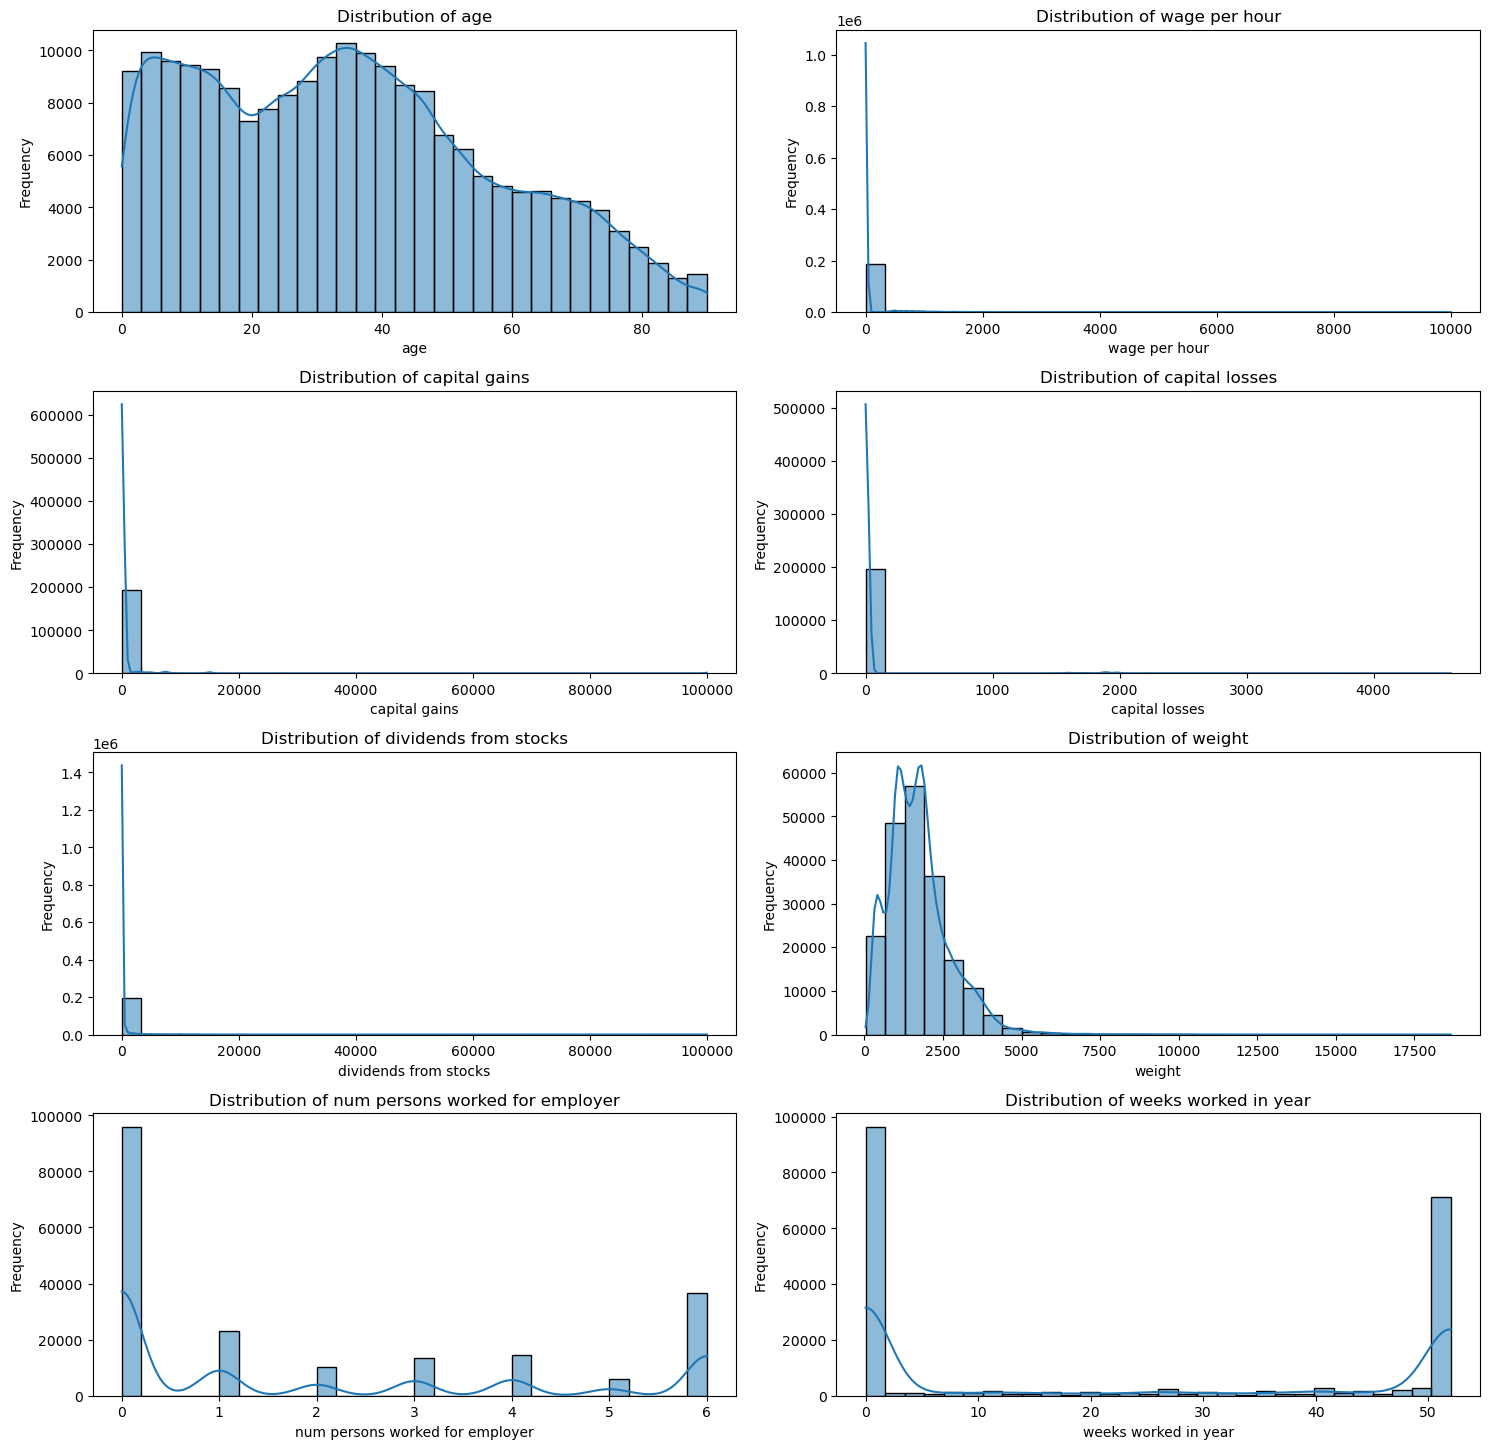

In [21]:
plt.figure(figsize=(15, 25))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(7, 2, i)
    sns.histplot(df[col], kde=True,  bins=30)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
df['num persons worked for employer'] = df['num persons worked for employer'].astype('category')

Since `num persons worked for employer` has discrete values, we convert it to `category` dtype.

In [23]:
# Z-score based outlier detection for near-normal features
def detect_outliers_normal(df, columns):
    outlier_summary = []
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = z_scores > 3
        outlier_count = np.sum(outliers)
        total_count = len(df[col])
        outlier_percentage = (outlier_count / total_count) * 100

        outlier_summary.append({
            'Column': col,
            'Outlier Count': outlier_count,
            'Total Count': total_count,
            'Outlier Percentage': round(outlier_percentage, 2)
        })

    return pd.DataFrame(outlier_summary)

# Log-transform + IQR-based outlier detection for skewed features
def detect_outliers_with_log(data, columns):
    outlier_summary = []

    for column in columns:
        # Apply log transform (log1p handles zeros)
        log_transformed = np.log1p(data[column])

        # Compute IQR
        Q1 = np.percentile(log_transformed, 25)
        Q3 = np.percentile(log_transformed, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = (log_transformed < lower_bound) | (log_transformed > upper_bound)
        outlier_count = np.sum(outliers)
        total_count = len(data[column])
        outlier_percentage = (outlier_count / total_count) * 100

        outlier_summary.append({
            'Column': column,
            'Outlier Count': outlier_count,
            'Total Count': total_count,
            'Outlier Percentage': round(outlier_percentage, 2)
        })

    return pd.DataFrame(outlier_summary), data

# From the above plots -
normal_like = ['age', 'weight']
skewed = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

zscore_outliers = detect_outliers_normal(df, normal_like)
iqr_outliers, df = detect_outliers_with_log(df, skewed)

df['num persons worked for employer'] = df['num persons worked for employer'].astype('category')

# Display results
print("Z-score based outliers (normal-like features):")
display(zscore_outliers)

print("\nLog + IQR based outliers (skewed features):")
display(iqr_outliers)

Z-score based outliers (normal-like features):


,Column,Outlier Count,Total Count,Outlier Percentage
0,age,0,199523,0.00
1,weight,2126,199523,1.07



Log + IQR based outliers (skewed features):


,Column,Outlier Count,Total Count,Outlier Percentage
0,wage per hour,11304,199523,5.67
1,capital gains,7379,199523,3.70
2,capital losses,3906,199523,1.96
3,dividends from stocks,21141,199523,10.60


In [24]:
zscore_cols: ['age', 'weight']  # near-normal
logiqr_cols: ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']  # skewed

### Exploratory Data Analysis (EDA)

In [25]:
# Categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

##### Univariate Analysis

Several categorical variables in this dataset contain the label ***“Not in Universe”*** (NIU). In census terminology, “Not in Universe” indicates that the question did not apply to that respondent, rather than being a true missing value.

Because of this, NIU values are not treated as NaN or missing, since they carry semantic meaning. They denote a valid group within the population.

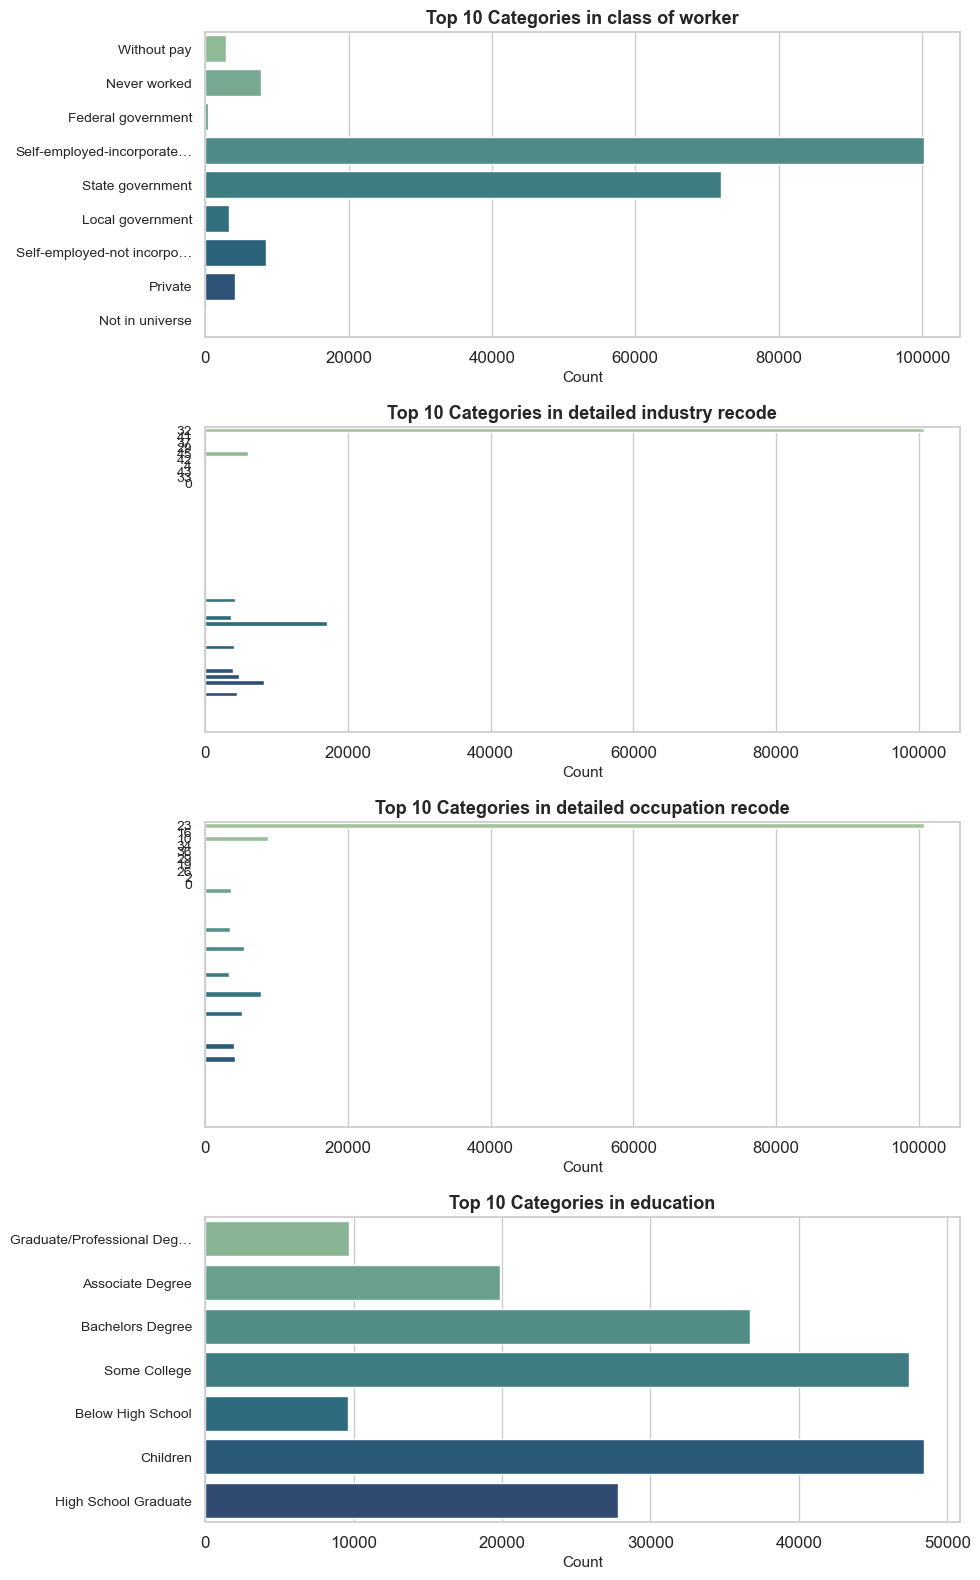

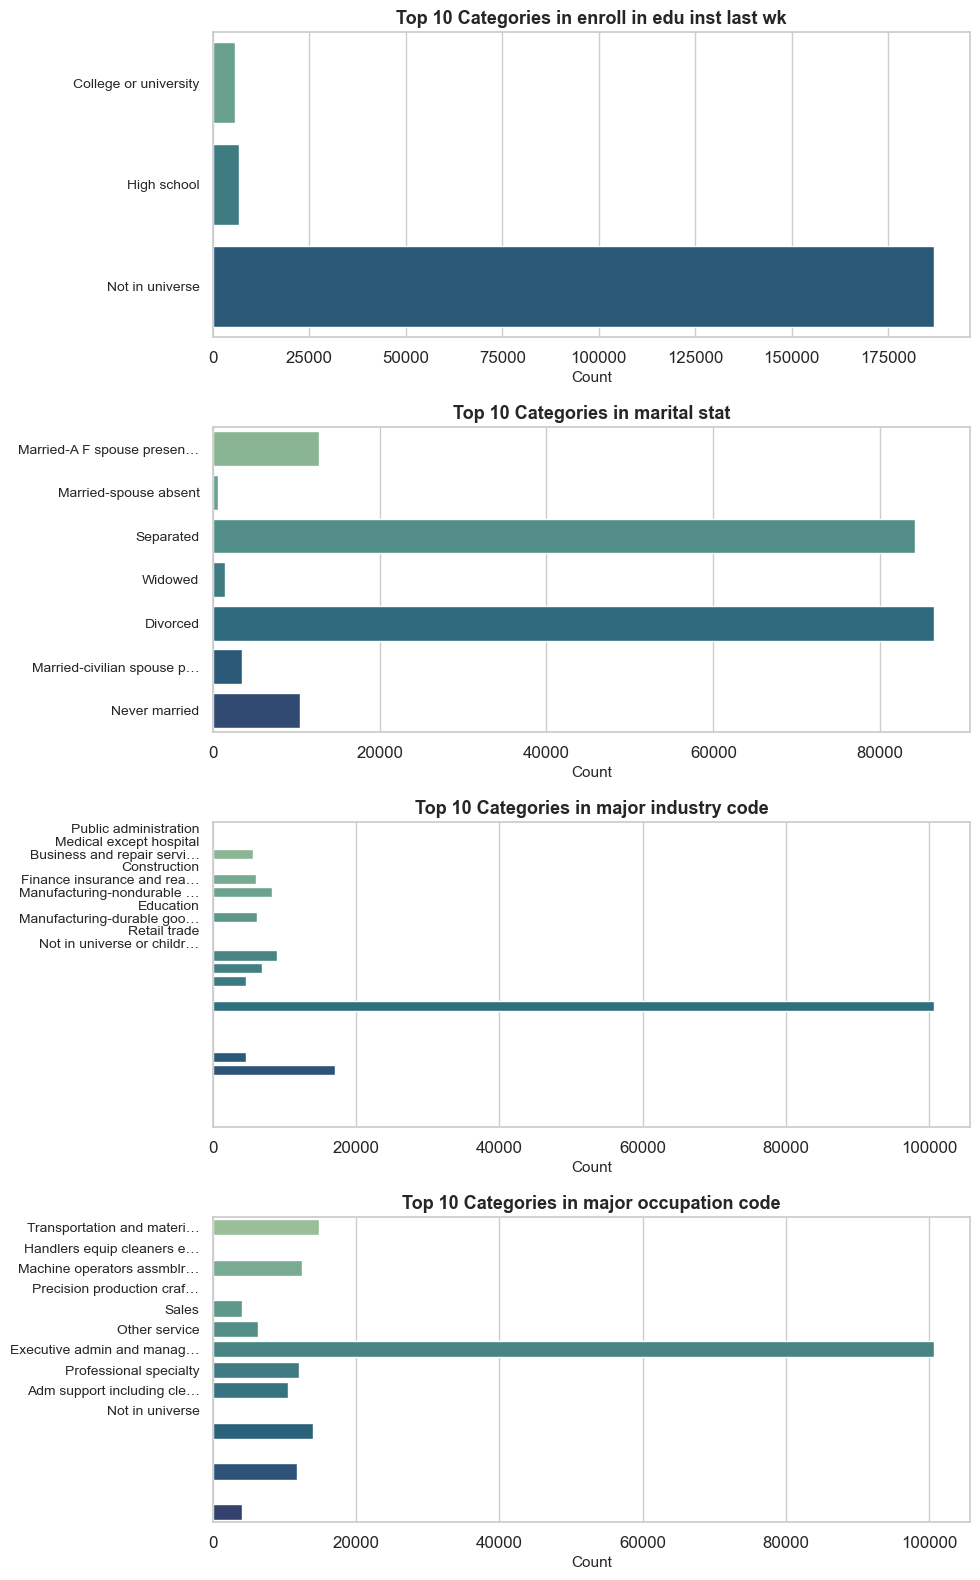

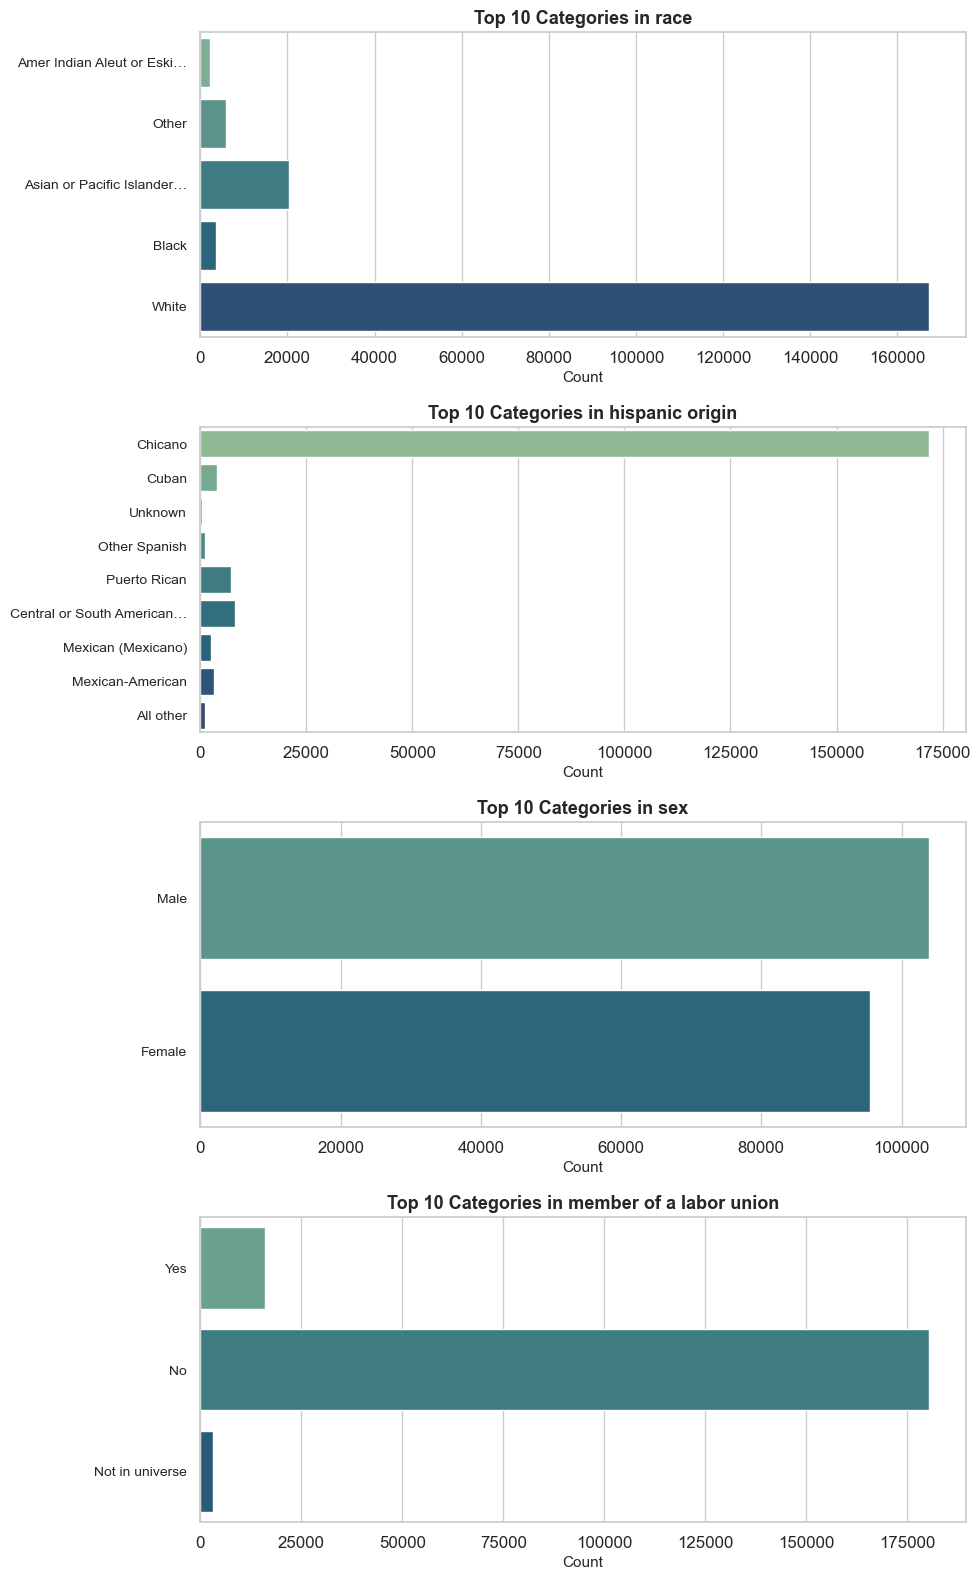

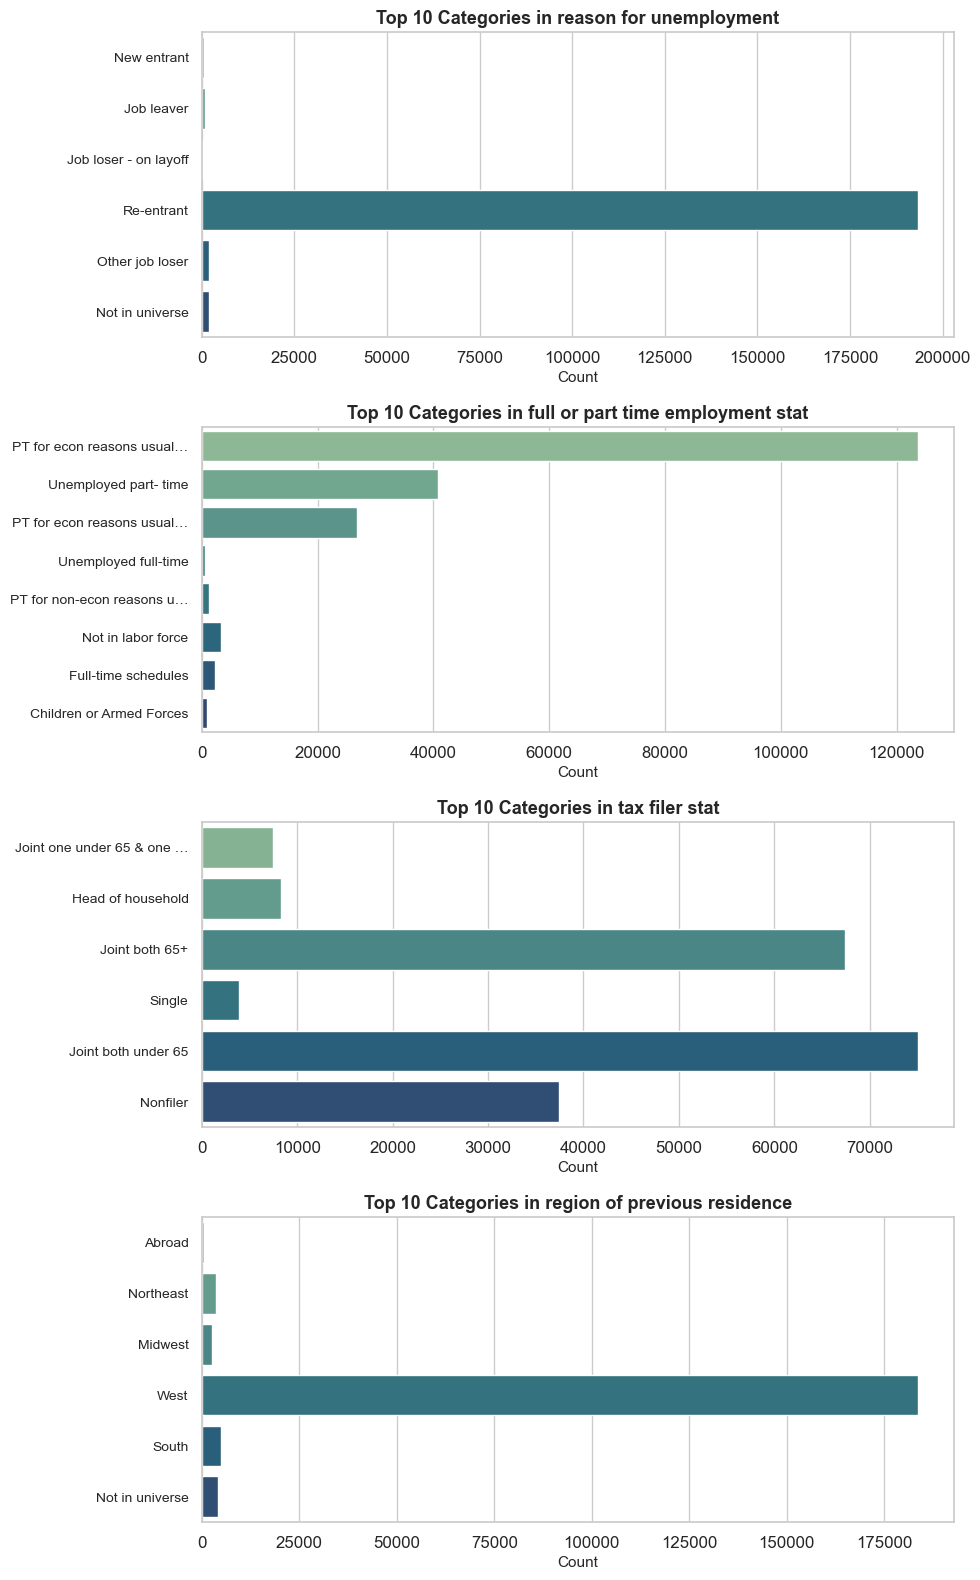

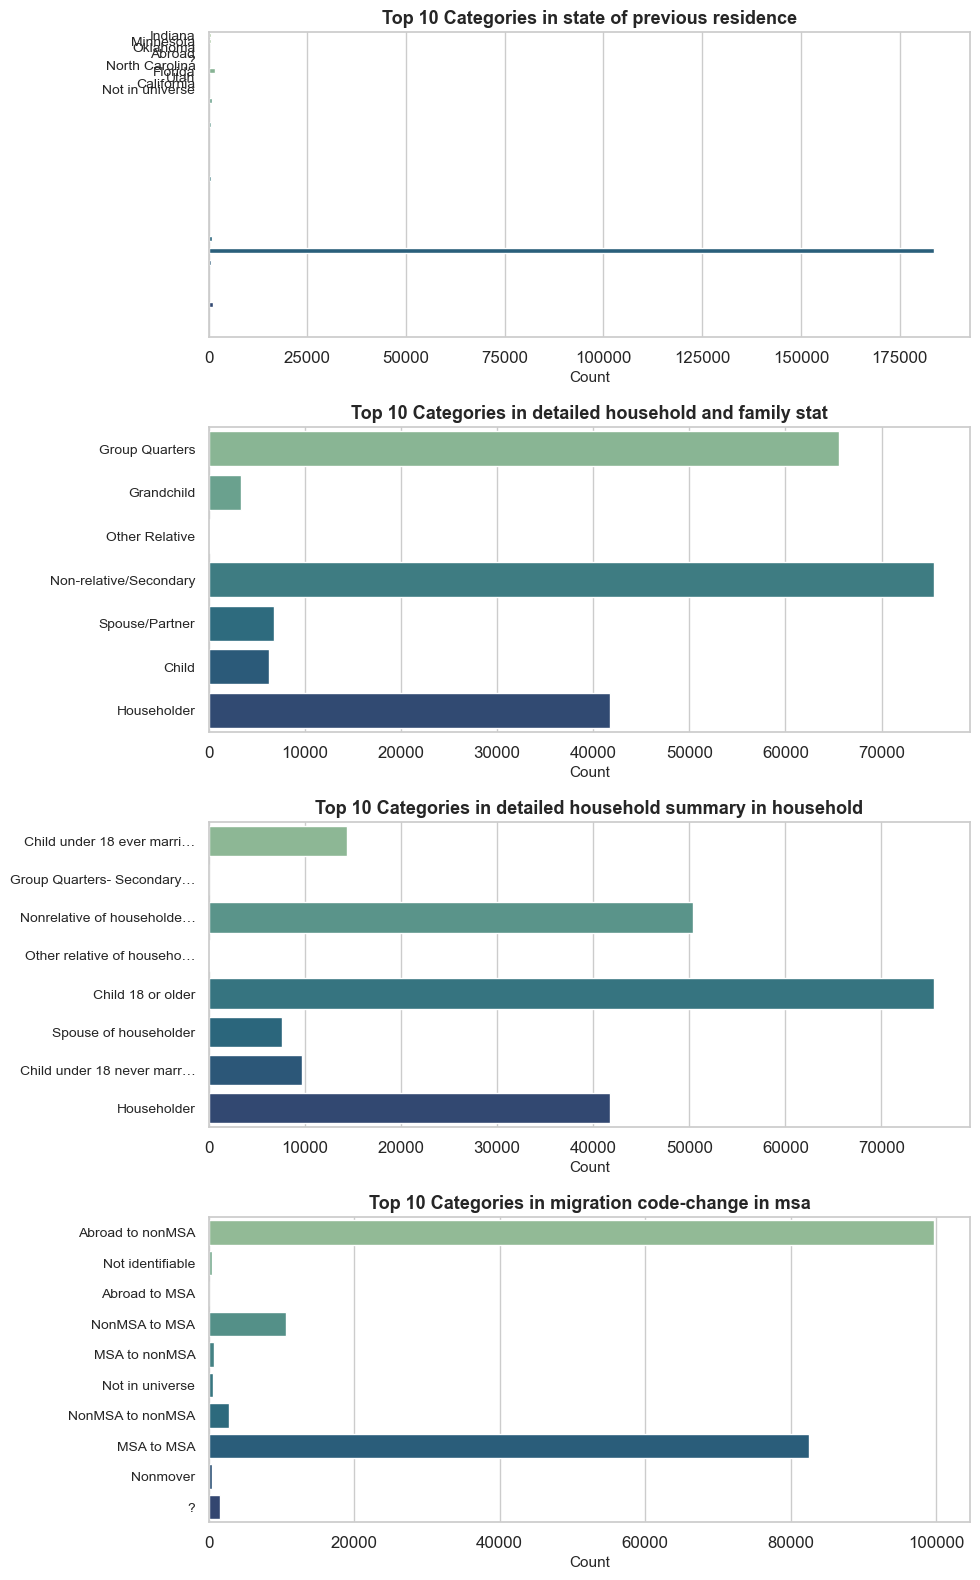

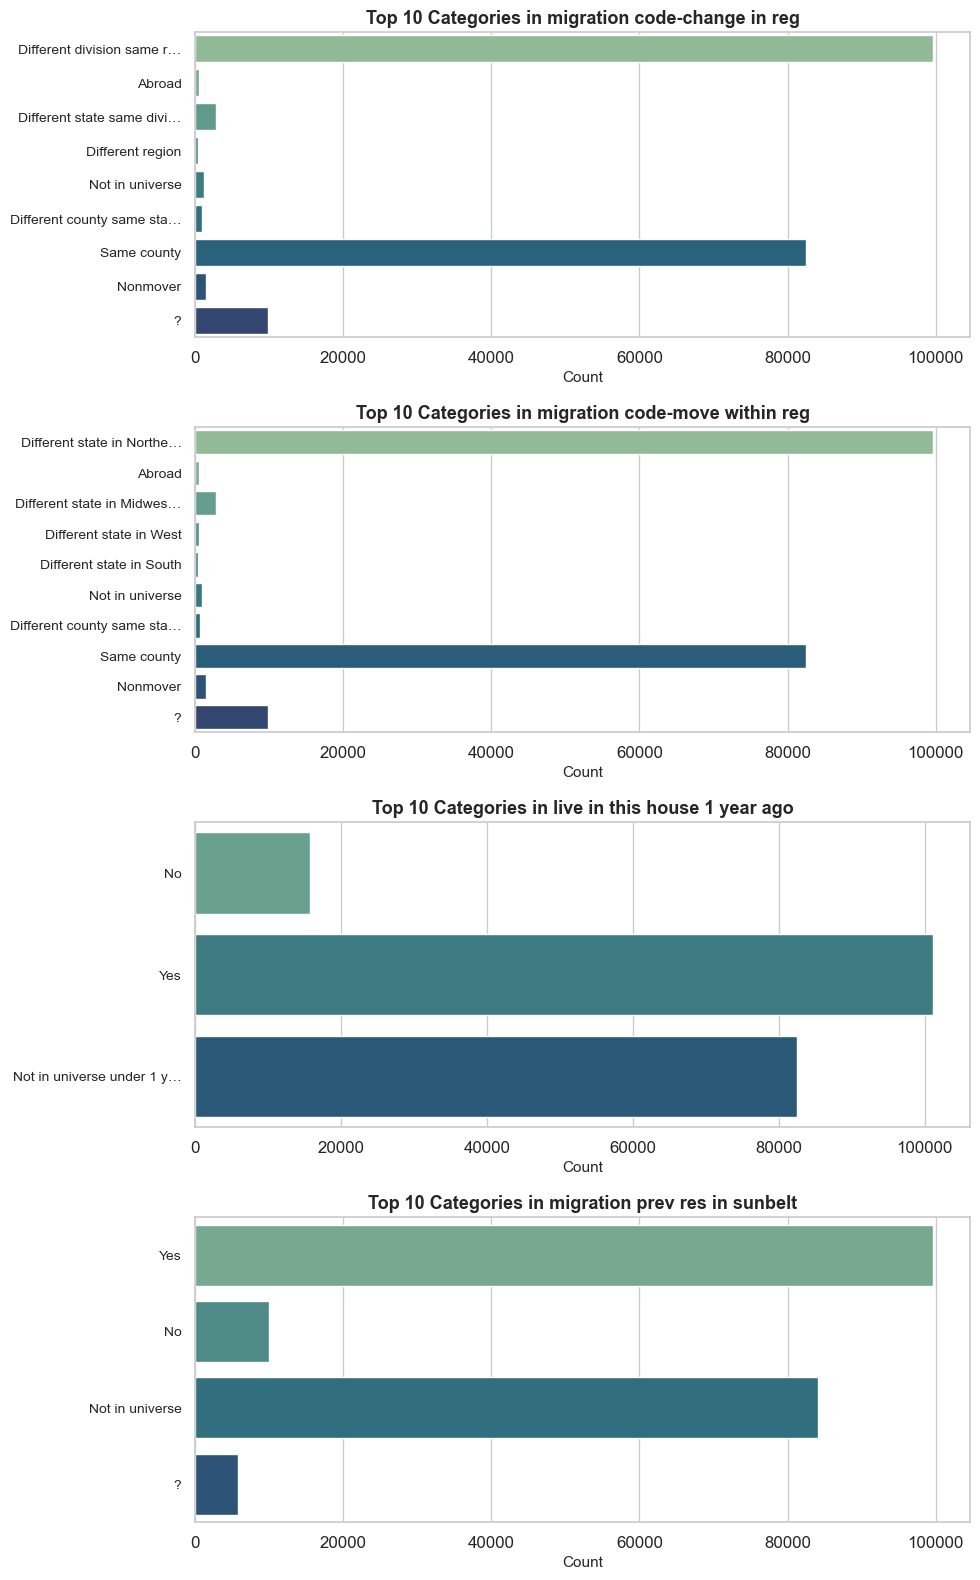

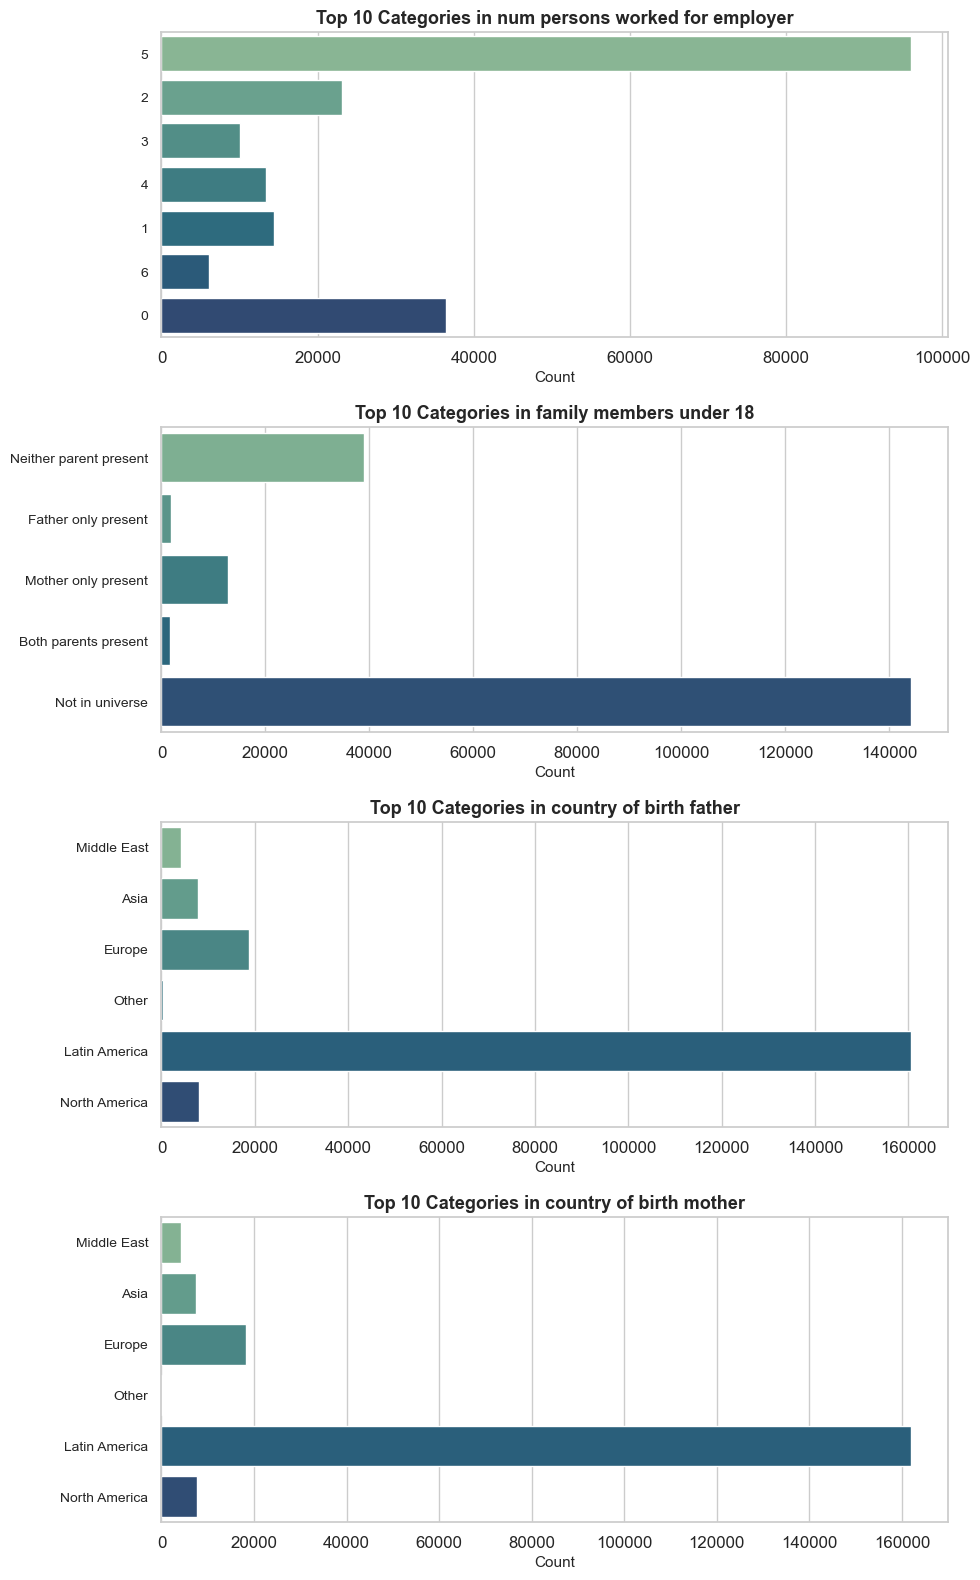

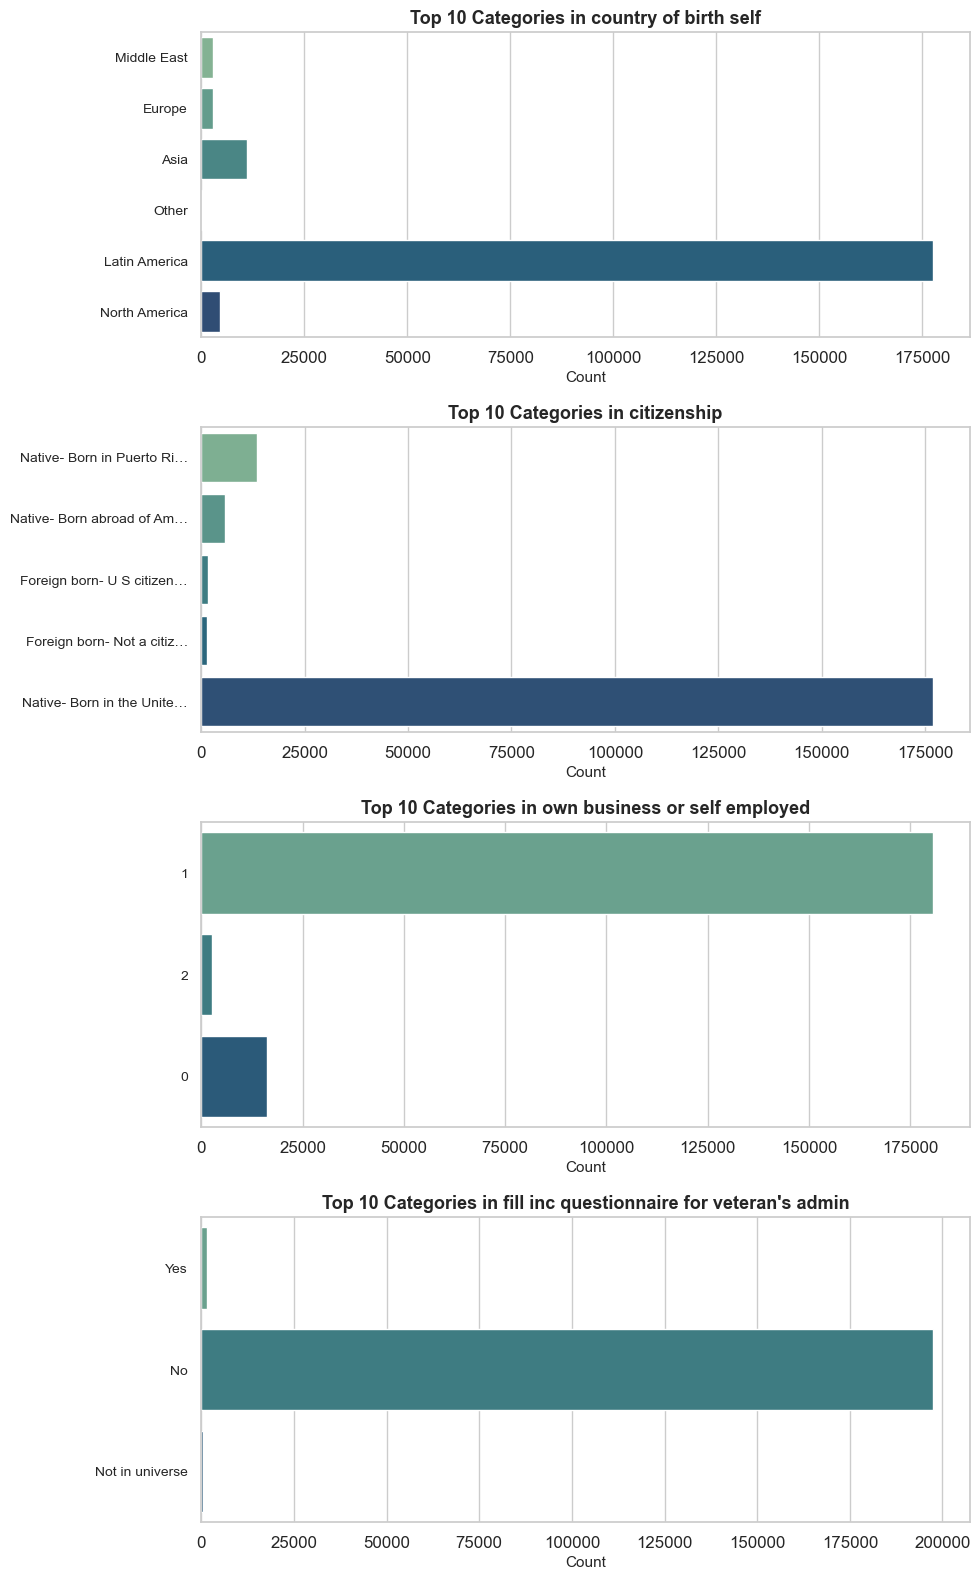

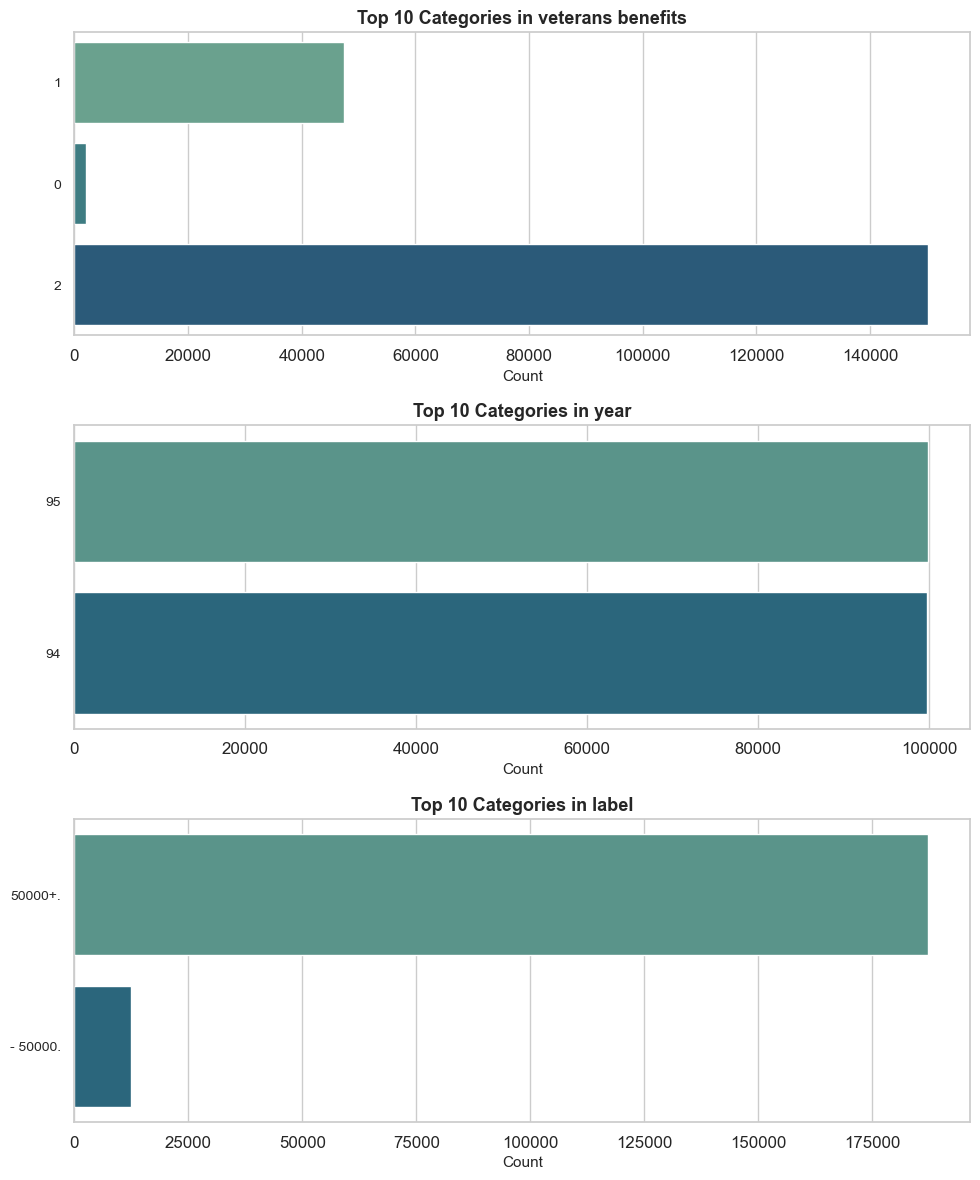

In [26]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
sns.set_theme(style="whitegrid", palette="crest", font_scale=1.1)
cols_per_fig = 4      # how many categorical vars per figure
top_n = 10            # show top N categories
plot_height = 4       # subplot height per variable

if len(categorical_cols) > 0:
    for start in range(0, len(categorical_cols), cols_per_fig):
        subset = categorical_cols[start:start + cols_per_fig]
        fig, axes = plt.subplots(len(subset), 1, figsize=(10, plot_height * len(subset)))
        if len(subset) == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            # --- Get top N categories sorted descending by count ---
            top_categories = df[col].value_counts().nlargest(top_n)
            top_categories = top_categories.sort_values(ascending=True)  # ascending so largest appears at top in horizontal bar
            sns.barplot(
                y=top_categories.index,
                x=top_categories.values,
                ax=ax,
                palette="crest"
            )
            ax.set_title(f"Top {top_n} Categories in {col}", fontsize=13, weight='bold')
            ax.set_xlabel("Count", fontsize=11)
            ax.set_ylabel("")
            ax.tick_params(axis='y', labelsize=10)

            # --- Truncate long labels for readability ---
            ax.set_yticklabels([t if len(str(t)) < 25 else str(t)[:25] + "…"
                                for t in top_categories.index])
        plt.tight_layout()
        plt.show()
else:
    print("No categorical columns found in the dataframe.")

##### Correlation Analysis

**To summarize:**
Performed an exhaustive correlation analysis to determine correlated variables across all combinations.
1. ***Spearman correlation*** was used for numeric–numeric pairs, since most numeric variables are non-normal and skewed, making Spearman (rank-based) more appropriate than Pearson.
2. ***Cramér’s V*** was applied to categorical–categorical pairs to measure the strength of association between discrete variables.
3. ***Correlation Ratio (η)*** was used for numeric–categorical pairs, capturing how much variance in the numeric variable can be explained by categorical groupings

In [27]:
# Cramer's V (Categorical-Categorical)
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Numeric-Categorical Correlation Ratio
def correlation_ratio(categories, values):
    categories = pd.Categorical(categories)
    cat_levels = categories.categories
    n_total = len(values)
    y_total_mean = np.nanmean(values)
    ss_between = 0
    for cat in cat_levels:
        cat_values = values[categories == cat]
        if len(cat_values) == 0:
            continue
        ss_between += len(cat_values) * (np.nanmean(cat_values) - y_total_mean) ** 2
    ss_total = np.nansum((values - y_total_mean) ** 2)
    if ss_total == 0:
        return 0
    return np.sqrt(ss_between / ss_total)

In [28]:
target = 'label'
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# Spearman correlation (Numeric-Numeric)
num_corr = df[num_cols].corr(method='spearman')
num_high = num_corr.where(abs(num_corr) > 0.8).stack().reset_index()
num_high.columns = ['Var1', 'Var2', 'Spearman_corr']
num_high = num_high[num_high['Var1'] != num_high['Var2']]
print("High Numeric–Numeric Correlations (|ρ| > 0.8):")
display(num_high.sort_values('Spearman_corr', ascending=False))

corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [col for col in upper.columns if any(upper[col] > 0.8)]

High Numeric–Numeric Correlations (|ρ| > 0.8):


,Var1,Var2,Spearman_corr


There are no significant numeric correlated variables.

In [29]:
# Cramer's V Correlation
cramers_results = []
checked_pairs = set()  # to track (var1, var2) combos

for c1 in cat_cols:
    for c2 in cat_cols:
        if c1 != c2 and (c2, c1) not in checked_pairs:  # skip reverse duplicates
            try:
                v = cramers_v(df[c1], df[c2])
                if v > 0.8:
                    cramers_results.append([c1, c2, v])
                checked_pairs.add((c1, c2))
            except:
                pass

cat_high = pd.DataFrame(cramers_results, columns=['Var1', 'Var2', "CramersV"])
print("\n High Categorical–Categorical Correlations (Cramér’s V > 0.8):")
display(cat_high.sort_values("CramersV", ascending=False))


 High Categorical–Categorical Correlations (Cramér’s V > 0.8):


,Var1,Var2,CramersV
16,migration prev res in sunbelt,year,0.999995
8,migration code-change in reg,live in this house 1 year ago,0.999985
10,migration code-change in reg,year,0.999982
11,migration code-move within reg,live in this house 1 year ago,0.999982
4,migration code-change in msa,live in this house 1 year ago,0.999982
13,migration code-move within reg,year,0.999980
6,migration code-change in msa,year,0.999980
0,detailed industry recode,major industry code,0.999930
1,detailed occupation recode,major occupation code,0.999920
14,live in this house 1 year ago,migration prev res in sunbelt,0.991778


In [30]:
# Numeric-Categorical Correlations
num_cat_results = []
for n in numeric_cols:
    for c in categorical_cols:
        try:
            val = correlation_ratio(df[c], df[n])
            if val > 0.8:
                num_cat_results.append([n, c, val])
        except:
            pass

num_cat_high = pd.DataFrame(num_cat_results, columns=['Numeric', 'Categorical', 'Correlation_Ratio'])
print("\n High Numeric–Categorical Correlations (η > 0.8):")
display(num_cat_high.sort_values('Correlation_Ratio', ascending=False))


 High Numeric–Categorical Correlations (η > 0.8):


,Numeric,Categorical,Correlation_Ratio
5,weeks worked in year,num persons worked for employer,0.914668
2,weeks worked in year,detailed occupation recode,0.885539
4,weeks worked in year,major occupation code,0.883026
1,weeks worked in year,detailed industry recode,0.882677
3,weeks worked in year,major industry code,0.882475
0,weeks worked in year,class of worker,0.879148


##### Correlation with target variable

In [31]:
# Correlation of categorical variables with target
cat_target_corr = []
for col in cat_cols:
    try:
        v = cramers_v(df[col], df[target])
        cat_target_corr.append([col, v])
    except:
        pass

cat_target_df = pd.DataFrame(cat_target_corr, columns=['Feature', 'CramersV_with_Target'])
cat_target_df = cat_target_df.sort_values('CramersV_with_Target', ascending=False)
display(cat_target_df.head(15))

,Feature,CramersV_with_Target
33,label,0.999957
2,detailed occupation recode,0.437947
3,education,0.378306
7,major occupation code,0.366169
1,detailed industry recode,0.292521
6,major industry code,0.277653
0,class of worker,0.260455
14,tax filer stat,0.229178
17,detailed household and family stat,0.227230
18,detailed household summary in household,0.227144


In [32]:
# Correlation of numeric variables with target (using correlation ratio)
def correlation_ratio(categories, values):
    categories = pd.Categorical(categories)
    values = pd.to_numeric(values, errors='coerce')
    mask = ~pd.isna(categories.codes) & ~pd.isna(values)
    if not mask.any():
        return 0.0
    categories = categories[mask]
    values = values[mask]
    y_mean = values.mean()
    ss_between = 0.0
    for cat in categories.categories:
        m = (categories == cat)
        if m.any():
            ss_between += m.sum() * (values[m].mean() - y_mean) ** 2
    ss_total = float(((values - y_mean) ** 2).sum())
    return float(np.sqrt(ss_between / ss_total)) if ss_total > 0 else 0.0
num_target_corr = []
for col in num_cols:
    try:
        eta = correlation_ratio(df[target], df[col])
        num_target_corr.append([col, eta])
    except:
        pass
num_target_df = pd.DataFrame(num_target_corr, columns=['Feature', 'CorrRatio_with_Target'])
num_target_df = num_target_df.sort_values('CorrRatio_with_Target', ascending=False)
display(num_target_df.head(15))

,Feature,CorrRatio_with_Target
6,weeks worked in year,0.262316
2,capital gains,0.240725
4,dividends from stocks,0.175779
3,capital losses,0.147417
0,age,0.135720
1,wage per hour,0.024528
5,weight,0.014463


**No significant correlations with target variable.**

After an exhaustive correlation analysis, we finalize:

Drop columns: `detailed industry recode`, `detailed occupation recode`,`migration code-change in msa`, `migration code-change in reg`, `migration code-move within reg`,`migration prev res in sunbelt`, `year`, `state of previous residence`,`detailed household summary in household`.

Retain:  `major industry code`,`major occupation code`,`live in this house 1 year ago`, `region of previous residence`,`detailed household and family stat`

In [33]:
drop_cols = [
    'detailed industry recode',
    'detailed occupation recode',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'migration prev res in sunbelt',
    'year',
    'state of previous residence',
    'detailed household summary in household'
]

In [34]:
df = df.drop(columns=drop_cols, errors='ignore')

### Splitting the Data

We first split the dataset into 70% train, 15% validation, and 15% test using stratified sampling to preserve the class balance.

In [35]:
X = df.drop(columns=['label'])
y = df['label']

In [36]:
# First split: Train + Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: Validation + Test (from Temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)

(159618, 32) (19952, 32) (19953, 32)


### Winsorization (applied only on the training set to avoid data leakage.)

To avoid data leakage, I applied winsorization only on the training set and then used the same IQR boundaries to cap values in the validation and test sets.

In [37]:
skewed_cols = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

In [38]:
def winsorize_iqr_train(series, k=1.5):
    """Cap values outside [Q1 - k*IQR, Q3 + k*IQR] range based on TRAIN data."""
    Q1 = np.percentile(series.dropna(), 25)
    Q3 = np.percentile(series.dropna(), 75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return lower, upper

iqr_bounds = {}
for col in skewed_cols:
    lower, upper = winsorize_iqr_train(X_train[col])
    iqr_bounds[col] = (lower, upper)

def apply_winsorization(df, bounds_dict):
    df_copy = df.copy()
    for col, (lower, upper) in bounds_dict.items():
        df_copy[col] = np.clip(df_copy[col], lower, upper)
    return df_copy

In [39]:
X_train_wins = apply_winsorization(X_train, iqr_bounds)
X_val_wins   = apply_winsorization(X_val, iqr_bounds)
X_test_wins  = apply_winsorization(X_test, iqr_bounds)

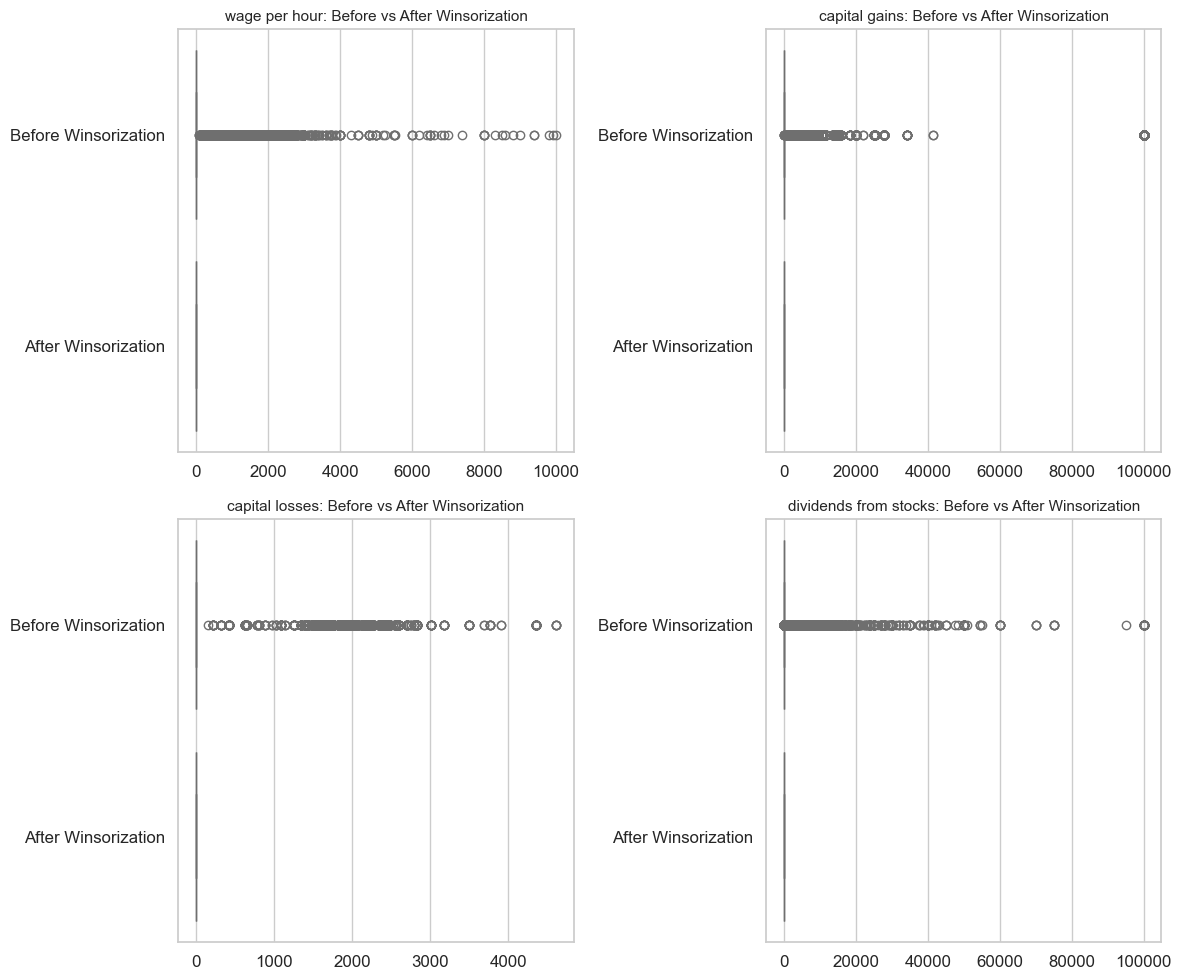

In [40]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(skewed_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=pd.DataFrame({
        'Before Winsorization': X_train[col],
        'After Winsorization': X_train_wins[col]
    }), orient='h', palette=['skyblue', 'lightgreen'])
    plt.title(f'{col}: Before vs After Winsorization', fontsize=11)
    plt.xlabel('')
plt.tight_layout()
plt.show()

### Encoding and Scaling

- `categorical` columns: encoded using OneHotEncoding
    - `education` had an inherent order (Children --> Below High School --> High School...) so it was encoded using Ordinal Encoding
- `numeric` columns: RobustScaler to handle skewed data well

In [41]:
edu_col = ['education'] if 'education' in X_train_wins.columns else []
edu_order = [['Children',
              'Below High School',
              'High School Graduate',
              'Some College',
              'Associate Degree',
              'Bachelors Degree',
              'Graduate/Professional Degree']]

cat_cols = [c for c in X_train_wins.select_dtypes(include=['object','category']).columns if c not in edu_col]
# excluding weight because weight here is a survey/sample weight
num_cols = [c for c in X_train_wins.select_dtypes(include=[np.number]).columns
            if c not in ['weight']]

In [42]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ord_enc = OrdinalEncoder(
    categories=edu_order if edu_col else 'auto',
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

coltx = ColumnTransformer(
    transformers=[
        ('num_robust', RobustScaler(), num_cols),
        ('cat_ohe',    ohe,            cat_cols),
        ('edu_ord',    ord_enc,        edu_col)
    ],
    remainder='drop'   # essentially dropping the weight column because applying SMOTE to handle imbalance, so need for weights
)

In [43]:
X_train_pre = coltx.fit_transform(X_train_wins)
X_val_pre   = coltx.transform(X_val_wins)
X_test_pre  = coltx.transform(X_test_wins)

In [44]:
# get feature names from the ColumnTransformer
feat_names = coltx.get_feature_names_out()
clean_feat_names = [name.split('__')[-1] for name in feat_names]
X_train_df = pd.DataFrame(X_train_pre, columns=clean_feat_names, index=X_train_wins.index)
X_val_df   = pd.DataFrame(X_val_pre,   columns=clean_feat_names, index=X_val_wins.index)
X_test_df  = pd.DataFrame(X_test_pre,  columns=clean_feat_names, index=X_test_wins.index)

X_train_df.shape, X_val_df.shape, X_test_df.shape

((159618, 164), (19952, 164), (19953, 164))

In [45]:
le = LabelEncoder()
y_train_df = le.fit_transform(y_train)

y_val_df = le.transform(y_val)
y_test_df = le.transform(y_test)
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'- 50000.': np.int64(0), '50000+.': np.int64(1)}


### SMOTE
Used SMOTE to handle minority class imbalance

In [46]:
from imblearn.over_sampling import SMOTE

# Check class distribution before SMOTE
print("\n=== Before SMOTE ===")
print(f"Train - Class 0: {sum(y_train_df==0)}, Class 1: {sum(y_train_df==1)}")
print(f"Train - Class distribution: {pd.Series(y_train_df).value_counts().to_dict()}")
print(f"Val   - Class 0: {sum(y_val_df==0)}, Class 1: {sum(y_val_df==1)}")
print(f"Test  - Class 0: {sum(y_test_df==0)}, Class 1: {sum(y_test_df==1)}")

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_df, y_train_df)

print("\n=== After SMOTE ===")
print(f"Train - Class 0: {sum(y_train_resampled==0)}, Class 1: {sum(y_train_resampled==1)}")
print(f"Train shape before: {X_train_df.shape}, after: {X_train_resampled.shape}")

# Convert back to DataFrame to maintain feature names (optional but recommended)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_df.columns)



=== Before SMOTE ===
Train - Class 0: 149712, Class 1: 9906
Train - Class distribution: {0: 149712, 1: 9906}
Val   - Class 0: 18714, Class 1: 1238
Test  - Class 0: 18715, Class 1: 1238

=== After SMOTE ===
Train - Class 0: 149712, Class 1: 149712
Train shape before: (159618, 164), after: (299424, 164)


### Modeling

#### Quick Workflow Overview for Modeling:
1. **Baseline Model:** To establish a reference point for all future improvements.
2. **Hyperparameter Tuning - Stage 1 - Randomized Search(Exploration Stage):** Identify promising regions by exploring a broad hyperparameter space
3. **Hyperparameter Tuning - Stage 2 - Grid Search (Refinement Stage):** A targetted grid search around the best areas discovered in Random Search
4. **Threshod Tuning:**
   - Threshold tuning helps convert model probabilities into class predictions in a way that’s optimized for the dataset and evaluation metric, rather than relying on a generic 0.5 rule.
   - The goal is to find the probability cutoff that optimally balances precision and recall for the specific problem.
5. **Evaluation:** Evaluate model performance on both validation and test sets using metrics like F1-score and precision–recall curves
6. **Visualization:** Plotting confusion matrices and precision–recall curves for each model
7. **Model Interpretability:** Understand what’s driving predictions using feature importance plots

In [47]:
#NEWWWWWWWWWWWW
def pick_best_threshold_by_f1(y_true, y_proba, pos_label=1):
    """Return threshold that maximizes F1 for positive class."""
    prec, rec, thr = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    f1_vals = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
    best_idx = np.argmax(f1_vals)
    return float(thr[best_idx]), prec, rec, thr, f1_vals

In [48]:
LABELS = le.classes_ if 'le' in globals() else None

# Initialize or reuse model_results table
try:
    model_results
except NameError:
    model_results = pd.DataFrame(columns=[
        "Model","Threshold",
        "Val_F1","Test_F1",
        "Val_ROC_AUC","Test_ROC_AUC",
        "Val_Recall","Test_Recall",
        "Val_Precision","Test_Precision"
    ])

#### 1. Random Forest Classification

Before SMOTE:
Train - Class 0: 149712, Class 1: 9906

After SMOTE:
Train - Class 0: 149712, Class 1: 149712


=== Random Forest with SMOTE — Baseline (Validation) ===

              precision    recall  f1-score   support

           0     0.9641    0.9757    0.9699     18714
           1     0.5514    0.4507    0.4960      1238

    accuracy                         0.9432     19952
   macro avg     0.7577    0.7132    0.7329     19952
weighted avg     0.9385    0.9432    0.9405     19952

ROC-AUC (val): 0.9269


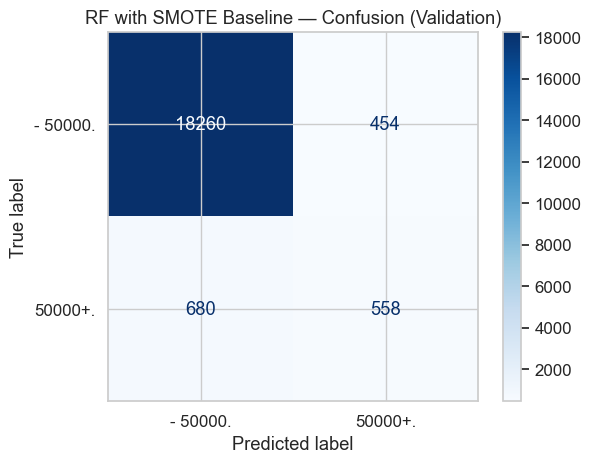


Fitting 2 folds for each of 8 candidates, totalling 16 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x104cddbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1068d9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103045bc0>
Traceback (most recent call last


RS best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}  | best F1 (cv): 0.9652
Fitting 2 folds for each of 3 candidates, totalling 6 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x107a91bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Grid best params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}  | best F1 (cv): 0.9653

=== Optimal Threshold (RF): 0.368 ===


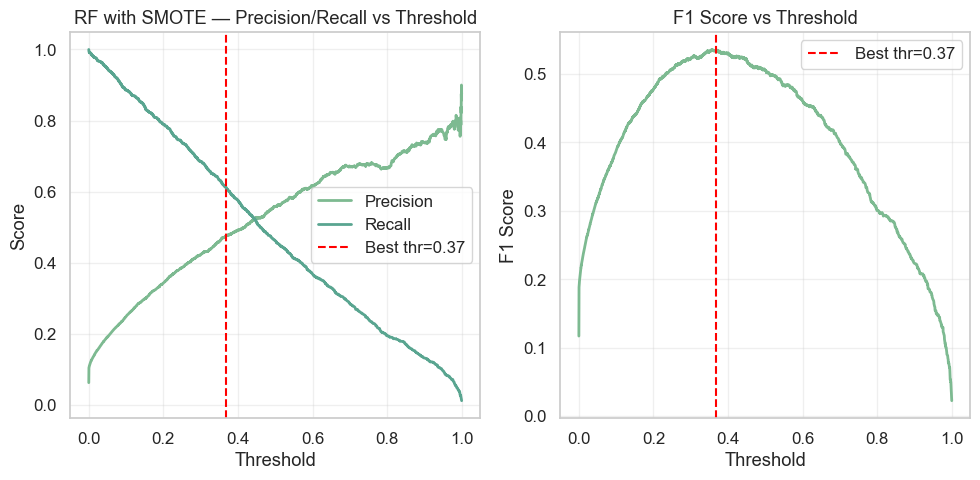



=== Random Forest with SMOTE — Validation (thr=0.37) ===

              precision    recall  f1-score   support

           0     0.9739    0.9553    0.9645     18714
           1     0.4759    0.6131    0.5358      1238

    accuracy                         0.9341     19952
   macro avg     0.7249    0.7842    0.7502     19952
weighted avg     0.9430    0.9341    0.9379     19952

ROC-AUC (val): 0.9312


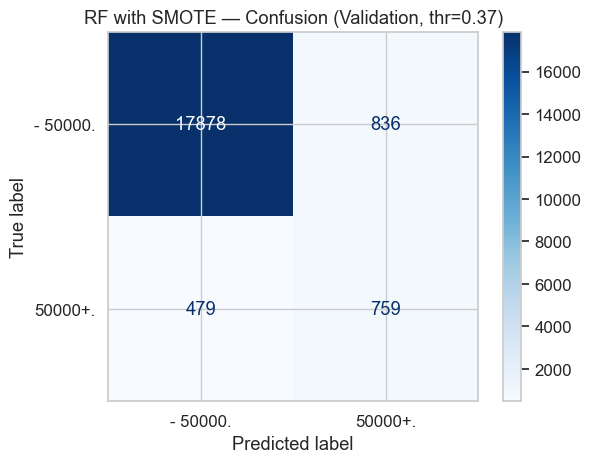




=== Random Forest with SMOTE — Test (thr=0.37) ===

              precision    recall  f1-score   support

           0     0.9712    0.9536    0.9623     18715
           1     0.4490    0.5719    0.5030      1238

    accuracy                         0.9299     19953
   macro avg     0.7101    0.7627    0.7327     19953
weighted avg     0.9388    0.9299    0.9338     19953

ROC-AUC (test): 0.9237


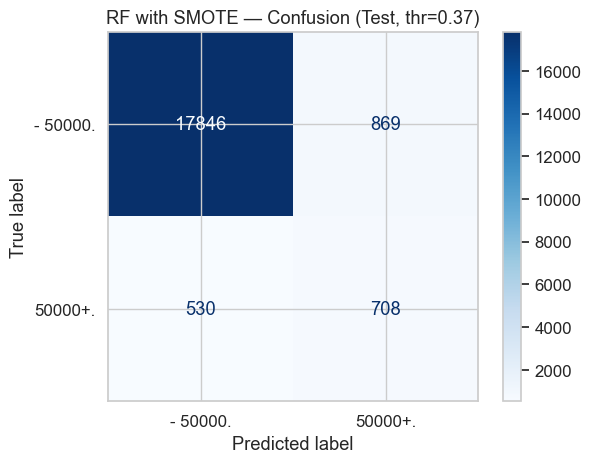



Top 15 features (RF with SMOTE):


,Feature,Importance
163,education,0.124209
0,age,0.103873
5,weeks worked in year,0.067732
112,detailed household and family stat_Householder,0.043116
119,num persons worked for employer_0,0.032352
78,sex_Female,0.030931
79,sex_Male,0.029619
101,tax filer stat_Nonfiler,0.028732
51,major occupation code_Executive admin and mana...,0.023294
55,major occupation code_Not in universe,0.022567


,Model,Threshold,Val_F1,Test_F1,Val_ROC_AUC,Test_ROC_AUC,Val_Recall,Test_Recall,Val_Precision,Test_Precision
0,RandomForest + SMOTE,0.367975,0.535828,0.50302,0.931216,0.923711,0.613086,0.57189,0.475862,0.448954


In [49]:
# === Random Forest (SMOTE + RS/GS + Threshold tuning) ===

rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight=None  # SMOTE used
)
rf_base.fit(X_train_resampled, y_train_resampled)

y_val_proba_base = rf_base.predict_proba(X_val_df)[:, 1]
y_val_pred_base  = (y_val_proba_base >= 0.5).astype(int)

print("\n" + "="*60)
print("\n=== Random Forest with SMOTE — Baseline (Validation) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred_base, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba_base), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred_base),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title("RF with SMOTE Baseline — Confusion (Validation)")
plt.show()
print("\n" + "="*60)

# 3) RandomizedSearchCV (small)
cv_rand = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_jobs=-1, random_state=42, class_weight=None
)

param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 8, 12],
    "max_features": ["sqrt", 0.5, 0.8],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True]
}

rf_rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=8,
    scoring="f1",
    cv=cv_rand,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_rs.fit(X_train_resampled, y_train_resampled)
print("\nRS best params:", rf_rs.best_params_, " | best F1 (cv):", round(rf_rs.best_score_, 4))

# 4) GridSearchCV (tiny, around RS best)
bp = rf_rs.best_params_
grid = {
    "n_estimators": sorted({max(100, bp["n_estimators"]-100), bp["n_estimators"], bp["n_estimators"]+100}),
    "max_depth": sorted({bp["max_depth"]} if bp["max_depth"] is None else {max(4, (bp["max_depth"] or 0)-2), bp["max_depth"], (bp["max_depth"] or 0)+2}),
    "max_features": sorted({bp["max_features"]}),
    "min_samples_split": sorted({bp["min_samples_split"]}),
    "min_samples_leaf": sorted({bp["min_samples_leaf"]}),
    "bootstrap": [bp["bootstrap"]]
}
rf_gs = GridSearchCV(
    estimator=rf,
    param_grid=grid,
    scoring="f1",
    cv=cv_rand,
    n_jobs=-1,
    verbose=1
)
rf_gs.fit(X_train_resampled, y_train_resampled)
best_rf = rf_gs.best_estimator_
print("Grid best params:", rf_gs.best_params_, " | best F1 (cv):", round(rf_gs.best_score_, 4))

# 5) Threshold tuning (by F1) on validation
def pick_best_threshold_by_f1(y_true, y_proba, pos_label=1):
    prec, rec, thr = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    f1_vals = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
    best_idx = np.argmax(f1_vals)
    return float(thr[best_idx]), prec, rec, thr

y_val_proba = best_rf.predict_proba(X_val_df)[:, 1]
best_thresh, prec, rec, thr = pick_best_threshold_by_f1(y_val_df, y_val_proba, pos_label=1)
print(f"\n=== Optimal Threshold (RF): {best_thresh:.3f} ===")

# Threshold curves (Precision/Recall & F1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(thr, prec[:-1], label="Precision", linewidth=2)
plt.plot(thr, rec[:-1],  label="Recall", linewidth=2)
plt.axvline(best_thresh, ls="--", color='r', label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("RF with SMOTE — Precision/Recall vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
f1_curve = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
plt.plot(thr, f1_curve, linewidth=2)
plt.axvline(best_thresh, ls="--", color='r', label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 Score vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 6) Validation evaluation
y_val_pred = (y_val_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== Random Forest with SMOTE — Validation (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"RF with SMOTE — Confusion (Validation, thr={best_thresh:.2f})")
plt.show()
print("\n" + "="*60)

# 7) Test evaluation
y_test_proba = best_rf.predict_proba(X_test_df)[:, 1]
y_test_pred  = (y_test_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== Random Forest with SMOTE — Test (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_test_df, y_test_pred, digits=4))
print("ROC-AUC (test):", round(roc_auc_score(y_test_df, y_test_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_test_df, y_test_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"RF with SMOTE — Confusion (Test, thr={best_thresh:.2f})")
plt.show()
print("\n" + "="*60)

# 8) Interpretability — feature importances
imp_df = pd.DataFrame({
    "Feature": X_train_resampled.columns,
    "Importance": best_rf.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nTop 15 features (RF with SMOTE):"); display(imp_df.head(15))

# 9) Record to comparison table
val_rep  = classification_report(y_val_df,  y_val_pred,  output_dict=True)
test_rep = classification_report(y_test_df, y_test_pred, output_dict=True)

rf_smote_row = pd.DataFrame([{
    "Model":"RandomForest + SMOTE",
    "Threshold":best_thresh,
    "Val_F1":val_rep["1"]["f1-score"],
    "Test_F1":test_rep["1"]["f1-score"],
    "Val_ROC_AUC":roc_auc_score(y_val_df, y_val_proba),
    "Test_ROC_AUC":roc_auc_score(y_test_df, y_test_proba),
    "Val_Recall":val_rep["1"]["recall"],
    "Test_Recall":test_rep["1"]["recall"],
    "Val_Precision":val_rep["1"]["precision"],
    "Test_Precision":test_rep["1"]["precision"]
}])

model_results = pd.concat([model_results, rf_smote_row], ignore_index=True)
display(model_results)

#### 2. XGBoost Classifier

Before SMOTE:
Train - Class 0: 149712, Class 1: 9906

After SMOTE:
Train - Class 0: 149712, Class 1: 149712
Scale_pos_weight after SMOTE: 1.00


=== XGBoost with SMOTE — Baseline (Validation) ===

              precision    recall  f1-score   support

           0     0.9724    0.9576    0.9649     18714
           1     0.4790    0.5889    0.5283      1238

    accuracy                         0.9347     19952
   macro avg     0.7257    0.7732    0.7466     19952
weighted avg     0.9418    0.9347    0.9379     19952

ROC-AUC (val): 0.9322



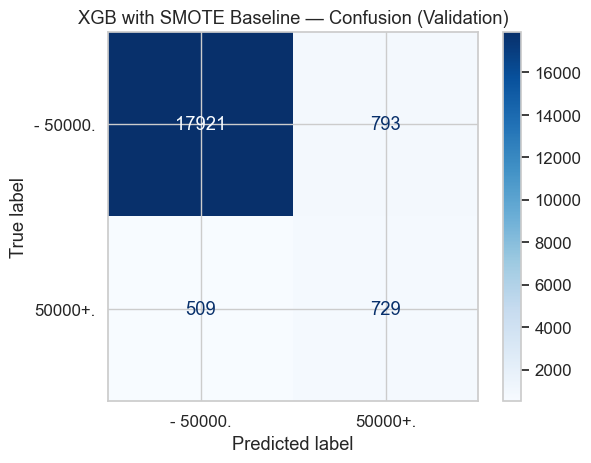


Fitting 2 folds for each of 4 candidates, totalling 8 fits

RS best params: {'subsample': 1.0, 'learning_rate': 0.05}  | best F1 (cv): 0.9244
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Grid best params: {'learning_rate': 0.07500000000000001}  | best F1 (cv): 0.9358

=== Optimal Threshold: 0.678 ===


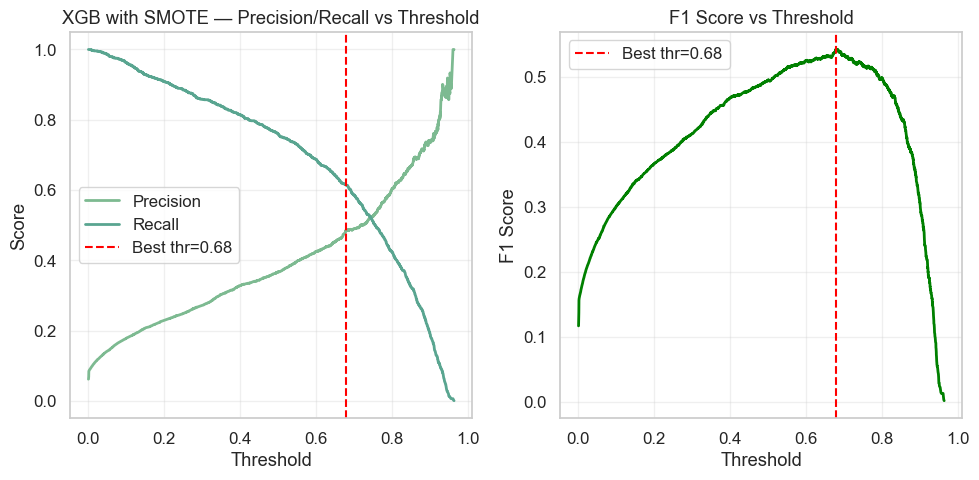



=== XGB with SMOTE — Validation (thr=0.68) ===

              precision    recall  f1-score   support

           0     0.9742    0.9566    0.9653     18714
           1     0.4844    0.6163    0.5425      1238

    accuracy                         0.9355     19952
   macro avg     0.7293    0.7865    0.7539     19952
weighted avg     0.9438    0.9355    0.9391     19952

ROC-AUC (val): 0.9344



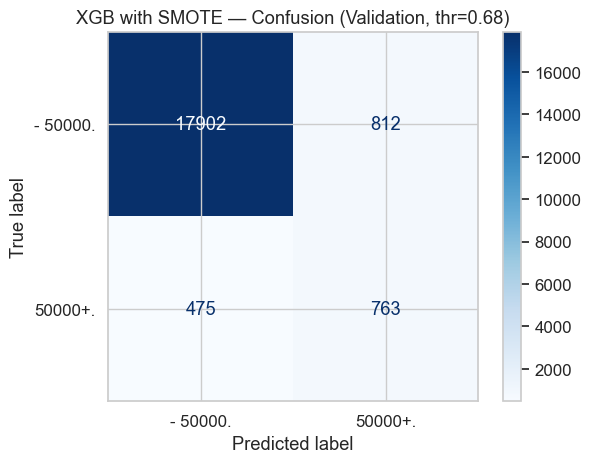




=== XGB with SMOTE — Test (thr=0.68) ===

              precision    recall  f1-score   support

           0     0.9720    0.9575    0.9647     18715
           1     0.4759    0.5832    0.5241      1238

    accuracy                         0.9343     19953
   macro avg     0.7240    0.7704    0.7444     19953
weighted avg     0.9412    0.9343    0.9374     19953

ROC-AUC (test): 0.9275



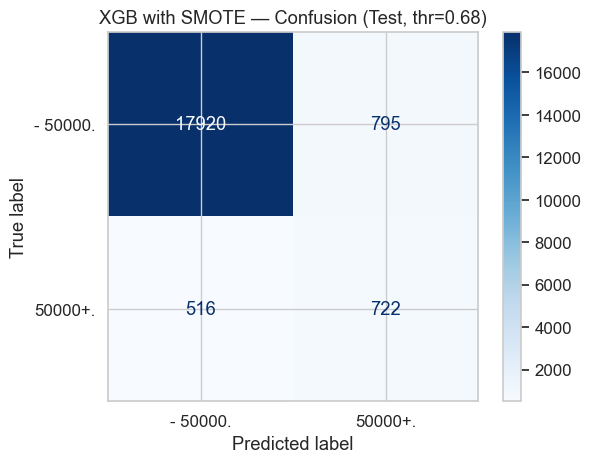



Top 15 features (XGB with SMOTE):


,Feature,Importance
5,weeks worked in year,0.134952
79,sex_Male,0.072658
101,tax filer stat_Nonfiler,0.057588
163,education,0.042464
112,detailed household and family stat_Householder,0.036742
69,hispanic origin_All other,0.029181
68,race_White,0.028356
109,detailed household and family stat_Child,0.025617
156,own business or self employed_2,0.024017
125,num persons worked for employer_6,0.023381


,Model,Threshold,Val_F1,Test_F1,Val_ROC_AUC,Test_ROC_AUC,Val_Recall,Test_Recall,Val_Precision,Test_Precision
0,RandomForest + SMOTE,0.367975,0.535828,0.503020,0.931216,0.923711,0.613086,0.571890,0.475862,0.448954
1,XGBoost + SMOTE,0.678014,0.542481,0.524138,0.934374,0.927480,0.616317,0.583199,0.484444,0.475939


In [50]:


# === SMOTE: Apply to training data only ===
print("Before SMOTE:")
print(f"Train - Class 0: {sum(y_train_df==0)}, Class 1: {sum(y_train_df==1)}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_df, y_train_df)

print("\nAfter SMOTE:")
print(f"Train - Class 0: {sum(y_train_resampled==0)}, Class 1: {sum(y_train_resampled==1)}")

# Convert back to DataFrame to maintain feature names
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_df.columns)

# Calculate scale_pos_weight on resampled data (should be ~1.0 after SMOTE)
neg, pos = np.bincount(y_train_resampled.astype(int))
scale_pos_weight = max(1.0, neg / max(pos, 1))
print(f"Scale_pos_weight after SMOTE: {scale_pos_weight:.2f}")

# 1) Baseline with SMOTE
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,  # ~1.0 after SMOTE, but keep for consistency
    random_state=42,
    n_jobs=-1
)
xgb_base.fit(X_train_resampled, y_train_resampled)

y_val_proba = xgb_base.predict_proba(X_val_df)[:, 1]
y_val_pred  = (y_val_proba >= 0.5).astype(int)
print("\n" + "="*60)
print("\n=== XGBoost with SMOTE — Baseline (Validation) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred), display_labels=le.classes_).plot(cmap="Blues", values_format="d")
print("\n" + "="*60)
plt.title("XGB with SMOTE Baseline — Confusion (Validation)"); plt.show()
print("\n" + "="*60)

# 2) RandomizedSearchCV (small) on resampled data
cv_rand = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

param_dist = {
   # "n_estimators": [200, 300],
   # "max_depth": [3, 5],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8, 1.0],
    #"colsample_bytree": [0.8, 1.0],
  #  "min_child_weight": [1, 3],
  #  "reg_lambda": [0.5, 1.0],
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,
    scoring="f1",
    cv=cv_rand,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_rs.fit(X_train_resampled, y_train_resampled)
print("\nRS best params:", xgb_rs.best_params_, " | best F1 (cv):", round(xgb_rs.best_score_, 4))

# 3) GridSearchCV (tiny)
bp = xgb_rs.best_params_
xgb_gs = GridSearchCV(
    estimator=xgb,
    param_grid={
        #"n_estimators": sorted({max(100, bp["n_estimators"]-100), bp["n_estimators"], bp["n_estimators"]+100}),
      #  "max_depth": sorted({max(2, bp["max_depth"]-1), bp["max_depth"], min(10, bp["max_depth"]+1)}),
        "learning_rate": sorted({max(0.02, bp["learning_rate"]/2), bp["learning_rate"], min(0.2, bp["learning_rate"]*1.5)})
    },
    scoring="f1",
    cv=cv_rand,
    n_jobs=-1,
    verbose=1
)
xgb_gs.fit(X_train_resampled, y_train_resampled)
best_xgb = xgb_gs.best_estimator_
print("Grid best params:", xgb_gs.best_params_, " | best F1 (cv):", round(xgb_gs.best_score_, 4))

# 4) Threshold tuning on validation
def pick_best_threshold_by_f1(y_true, y_proba, pos_label=1):
    """Return threshold that maximizes F1 for positive class."""
    prec, rec, thr = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    f1_vals = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
    best_idx = np.argmax(f1_vals)
    return float(thr[best_idx]), prec, rec, thr

y_val_proba = best_xgb.predict_proba(X_val_df)[:, 1]
best_thresh, prec, rec, thr = pick_best_threshold_by_f1(y_val_df, y_val_proba, pos_label=1)

print(f"\n=== Optimal Threshold: {best_thresh:.3f} ===")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thr, prec[:-1], label="Precision", linewidth=2)
plt.plot(thr, rec[:-1],  label="Recall", linewidth=2)
plt.axvline(best_thresh, ls="--", color='r', label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("XGB with SMOTE — Precision/Recall vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
f1_curve = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
plt.plot(thr, f1_curve, linewidth=2, color='green')
plt.axvline(best_thresh, ls="--", color='r', label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 Score vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Validation & Test
y_val_pred = (y_val_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== XGB with SMOTE — Validation (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred), display_labels=le.classes_).plot(cmap="Blues", values_format="d")
print("\n" + "="*60)
plt.title(f"XGB with SMOTE — Confusion (Validation, thr={best_thresh:.2f})"); plt.show()
print("\n" + "="*60)

y_test_proba = best_xgb.predict_proba(X_test_df)[:, 1]
y_test_pred  = (y_test_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== XGB with SMOTE — Test (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_test_df, y_test_pred, digits=4))
print("ROC-AUC (test):", round(roc_auc_score(y_test_df, y_test_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_test_df, y_test_pred), display_labels=le.classes_).plot(cmap="Blues", values_format="d")
print("\n" + "="*60)
plt.title(f"XGB with SMOTE — Confusion (Test, thr={best_thresh:.2f})"); plt.show()
print("\n" + "="*60)

# 6) Interpretability
imp_df = pd.DataFrame({
    "Feature": X_train_resampled.columns,
    "Importance": best_xgb.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nTop 15 features (XGB with SMOTE):"); display(imp_df.head(15))

# 7) Record to comparison table
val_rep  = classification_report(y_val_df,  y_val_pred,  output_dict=True)
test_rep = classification_report(y_test_df, y_test_pred, output_dict=True)
xgb_smote_row = pd.DataFrame([{
    "Model":"XGBoost + SMOTE",
    "Threshold":best_thresh,
    "Val_F1":val_rep["1"]["f1-score"],
    "Test_F1":test_rep["1"]["f1-score"],
    "Val_ROC_AUC":roc_auc_score(y_val_df,y_val_proba),
    "Test_ROC_AUC":roc_auc_score(y_test_df,y_test_proba),
    "Val_Recall":val_rep["1"]["recall"],
    "Test_Recall":test_rep["1"]["recall"],
    "Val_Precision":val_rep["1"]["precision"],
    "Test_Precision":test_rep["1"]["precision"]
}])
model_results = pd.concat([model_results, xgb_smote_row], ignore_index=True)
display(model_results)

#### 3. LightGBM

Before SMOTE:
Train - Class 0: 149712, Class 1: 9906

After SMOTE:
Train - Class 0: 149712, Class 1: 149712


=== LightGBM with SMOTE — Baseline (Validation) ===

              precision    recall  f1-score   support

           0     0.9660    0.9742    0.9701     18714
           1     0.5528    0.4822    0.5151      1238

    accuracy                         0.9437     19952
   macro avg     0.7594    0.7282    0.7426     19952
weighted avg     0.9404    0.9437    0.9419     19952

ROC-AUC (val): 0.9344


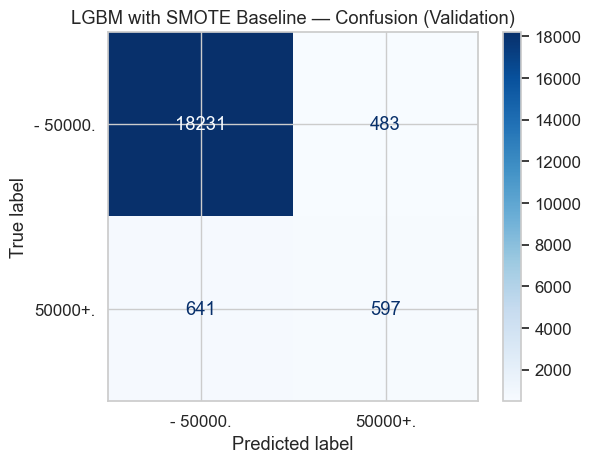



RS best params: {'subsample': 0.8, 'reg_lambda': 1.0, 'num_leaves': 63, 'n_estimators': 900, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.08, 'colsample_bytree': 1.0}  | best F1 (cv): 0.9668
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with un

Exception ignored in: <function ResourceTracker.__del__ at 0x106829bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104fd5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


Exception ignored in: <function ResourceTracker.__del__ at 0x106d05bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1025b9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1030b5bc0>
Traceback (most recent call last

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in

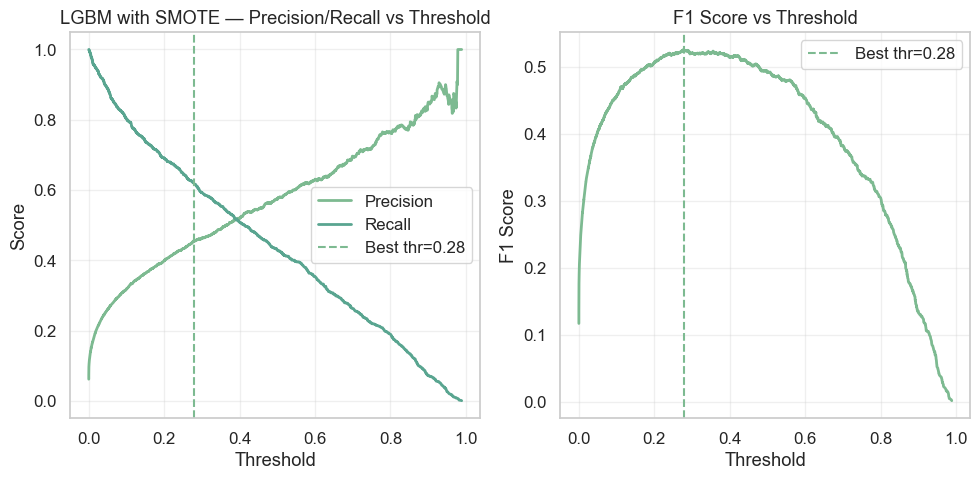



=== LightGBM with SMOTE — Validation (thr=0.28) ===

              precision    recall  f1-score   support

           0     0.9743    0.9510    0.9625     18714
           1     0.4558    0.6204    0.5255      1238

    accuracy                         0.9305     19952
   macro avg     0.7150    0.7857    0.7440     19952
weighted avg     0.9421    0.9305    0.9354     19952

ROC-AUC (val): 0.9335


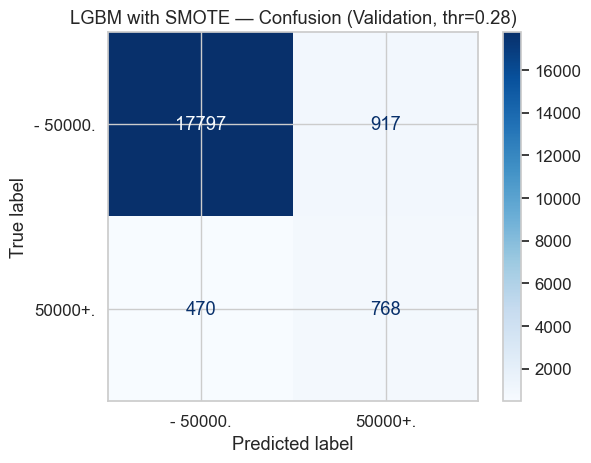



=== LightGBM with SMOTE — Test (thr=0.28) ===

              precision    recall  f1-score   support

           0     0.9737    0.9491    0.9613     18715
           1     0.4433    0.6131    0.5146      1238

    accuracy                         0.9282     19953
   macro avg     0.7085    0.7811    0.7379     19953
weighted avg     0.9408    0.9282    0.9335     19953

ROC-AUC (test): 0.9249


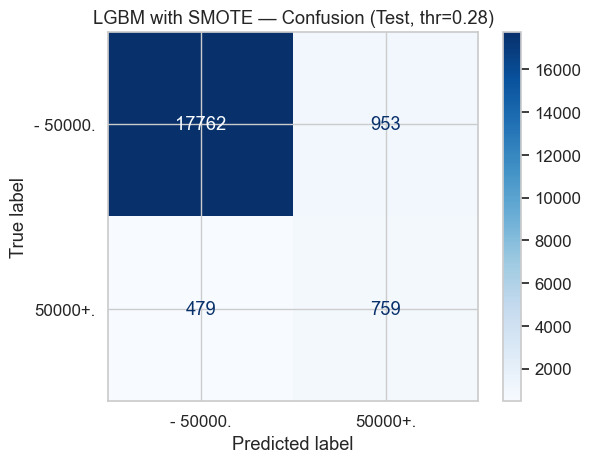


Top 15 features (LGBM with SMOTE):


,Feature,Importance
0,age,31138
163,education,11219
5,weeks worked in year,6789
125,num persons worked for employer_6,2811
51,major occupation code_Executive admin and mana...,2330
78,sex_Female,2239
90,full or part time employment stat_Full-time sc...,2132
112,detailed household and family stat_Householder,2065
10,class of worker_Private,1891
118,live in this house 1 year ago_Yes,1852


,Model,Threshold,Val_F1,Test_F1,Val_ROC_AUC,Test_ROC_AUC,Val_Recall,Test_Recall,Val_Precision,Test_Precision
0,RandomForest + SMOTE,0.367975,0.535828,0.503020,0.931216,0.923711,0.613086,0.571890,0.475862,0.448954
1,XGBoost + SMOTE,0.678014,0.542481,0.524138,0.934374,0.927480,0.616317,0.583199,0.484444,0.475939
2,LightGBM + SMOTE,0.278373,0.525488,0.514576,0.933480,0.924900,0.620355,0.613086,0.455786,0.443341


In [51]:
# === LightGBM (SMOTE + RS/GS + Threshold tuning) ===

# 2) Baseline LGBM (quick)
lgb_base = LGBMClassifier(
    objective="binary",
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,               # -1 = no limit
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_samples=20,
    reg_lambda=1.0,
    random_state=42,
    verbosity=-1,
    n_jobs=-1
)
lgb_base.fit(X_train_resampled, y_train_resampled)
y_val_proba_base = lgb_base.predict_proba(X_val_df)[:, 1]
y_val_pred_base  = (y_val_proba_base >= 0.5).astype(int)

print("\n" + "="*60)
print("\n=== LightGBM with SMOTE — Baseline (Validation) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred_base, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba_base), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred_base),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title("LGBM with SMOTE Baseline — Confusion (Validation)")
plt.show()
print("\n" + "="*60)

# 3) RandomizedSearchCV (small)
cv_rand = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lgb = LGBMClassifier(objective="binary", random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [300, 600, 900],
    "learning_rate": [0.03, 0.05, 0.08],
    "num_leaves": [31, 63],
    "max_depth": [-1, 8, 12],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_samples": [10, 20, 40],
    "reg_lambda": [0.0, 1.0]
}

lgb_rs = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=cv_rand,
    n_jobs=1,          
    random_state=42,
    verbose=0
)
lgb_rs.fit(X_train_resampled, y_train_resampled)
print("\nRS best params:", lgb_rs.best_params_, " | best F1 (cv):", round(lgb_rs.best_score_, 4))

# 4) GridSearchCV (tiny around RS best)
bp = lgb_rs.best_params_
lgb_gs = GridSearchCV(
    estimator=LGBMClassifier(objective="binary", random_state=42, n_jobs=-1, verbose=0, force_row_wise=True),
    param_grid={
        "n_estimators": sorted({max(200, bp["n_estimators"]-200), bp["n_estimators"], bp["n_estimators"]+200}),
        "learning_rate": sorted({max(0.02, bp["learning_rate"]/2), bp["learning_rate"], min(0.2, bp["learning_rate"]*1.5)}),
        "num_leaves": sorted({max(15, bp["num_leaves"]//2), bp["num_leaves"], min(255, bp["num_leaves"]*2)}),
    },
    scoring="f1",
    cv=cv_rand,
    n_jobs=1,
    verbose=0
)
lgb_gs.fit(X_train_resampled, y_train_resampled)
best_lgb = lgb_gs.best_estimator_
print("Grid best params:", lgb_gs.best_params_, " | best F1 (cv):", round(lgb_gs.best_score_, 4))

# 5) Threshold tuning (by F1) on validation
def pick_best_threshold_by_f1(y_true, y_proba, pos_label=1):
    prec, rec, thr = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    f1_vals = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
    best_idx = np.argmax(f1_vals)
    return float(thr[best_idx]), prec, rec, thr

y_val_proba = best_lgb.predict_proba(X_val_df)[:, 1]
best_thresh, prec, rec, thr = pick_best_threshold_by_f1(y_val_df, y_val_proba, pos_label=1)
print(f"\n=== Optimal Threshold (LGBM): {best_thresh:.3f} ===")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(thr, prec[:-1], label="Precision", linewidth=2)
plt.plot(thr, rec[:-1],  label="Recall", linewidth=2)
plt.axvline(best_thresh, ls="--", label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("LGBM with SMOTE — Precision/Recall vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
f1_curve = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
plt.plot(thr, f1_curve, linewidth=2)
plt.axvline(best_thresh, ls="--", label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 Score vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 6) Validation evaluation
y_val_pred = (y_val_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== LightGBM with SMOTE — Validation (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"LGBM with SMOTE — Confusion (Validation, thr={best_thresh:.2f})")
plt.show()

# 7) Test evaluation
y_test_proba = best_lgb.predict_proba(X_test_df)[:, 1]
y_test_pred  = (y_test_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== LightGBM with SMOTE — Test (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_test_df, y_test_pred, digits=4))
print("ROC-AUC (test):", round(roc_auc_score(y_test_df, y_test_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_test_df, y_test_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"LGBM with SMOTE — Confusion (Test, thr={best_thresh:.2f})")
plt.show()

# 8) Feature importance
imp_df = pd.DataFrame({
    "Feature": X_train_resampled.columns,
    "Importance": best_lgb.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nTop 15 features (LGBM with SMOTE):"); display(imp_df.head(15))

# 9) Append to results table
val_rep  = classification_report(y_val_df,  y_val_pred,  output_dict=True)
test_rep = classification_report(y_test_df, y_test_pred, output_dict=True)

lgb_row = pd.DataFrame([{
    "Model":"LightGBM + SMOTE",
    "Threshold":best_thresh,
    "Val_F1":val_rep["1"]["f1-score"],
    "Test_F1":test_rep["1"]["f1-score"],
    "Val_ROC_AUC":roc_auc_score(y_val_df, y_val_proba),
    "Test_ROC_AUC":roc_auc_score(y_test_df, y_test_proba),
    "Val_Recall":val_rep["1"]["recall"],
    "Test_Recall":test_rep["1"]["recall"],
    "Val_Precision":val_rep["1"]["precision"],
    "Test_Precision":test_rep["1"]["precision"]
}])

model_results = pd.concat([model_results, lgb_row], ignore_index=True)
display(model_results)

#### CatBoost

Before SMOTE:
Train - Class 0: 149712, Class 1: 9906

After SMOTE:
Train - Class 0: 149712, Class 1: 149712


=== CatBoost with SMOTE — Baseline (Validation) ===

              precision    recall  f1-score   support

           0     0.9662    0.9737    0.9699     18714
           1     0.5495    0.4847    0.5150      1238

    accuracy                         0.9434     19952
   macro avg     0.7578    0.7292    0.7425     19952
weighted avg     0.9403    0.9434    0.9417     19952

ROC-AUC (val): 0.9346


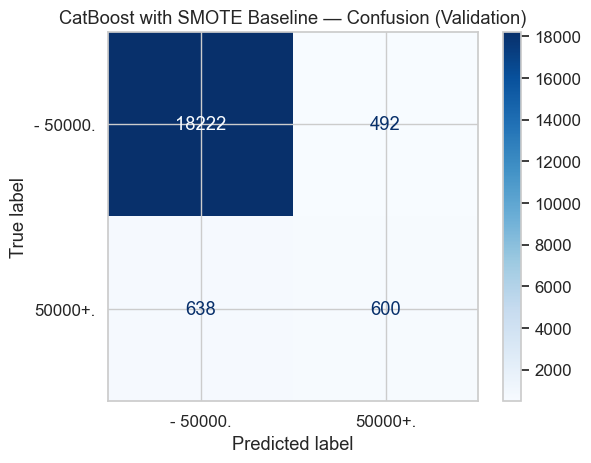


Fitting 2 folds for each of 10 candidates, totalling 20 fits

RS best params: {'subsample': 1.0, 'learning_rate': 0.08, 'l2_leaf_reg': 1.0, 'iterations': 800, 'depth': 8}  | best F1 (cv): 0.9665
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Grid best params: {'depth': 10, 'iterations': 1100, 'learning_rate': 0.12}  | best F1 (cv): 0.9675

=== Optimal Threshold (CatBoost): 0.337 ===


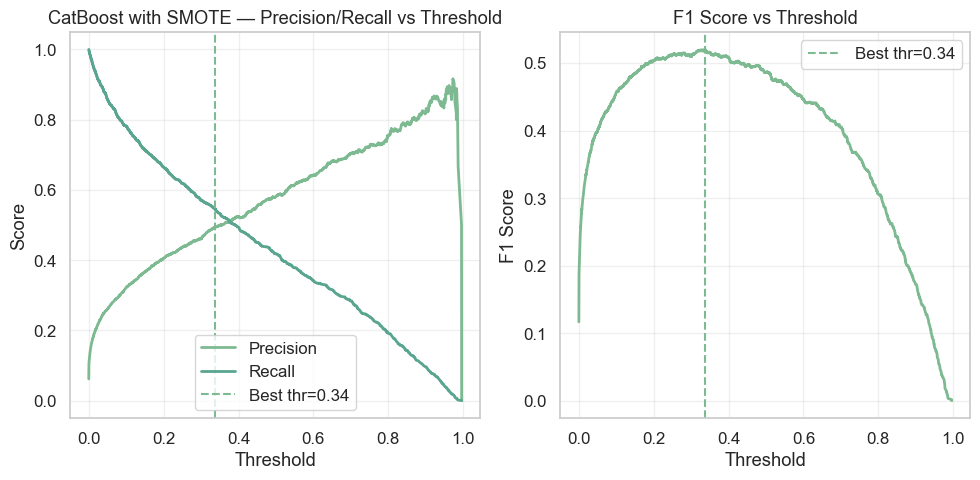



=== CatBoost with SMOTE — Validation (thr=0.34) ===

              precision    recall  f1-score   support

           0     0.9699    0.9631    0.9665     18714
           1     0.4953    0.5477    0.5201      1238

    accuracy                         0.9373     19952
   macro avg     0.7326    0.7554    0.7433     19952
weighted avg     0.9404    0.9373    0.9388     19952

ROC-AUC (val): 0.9296


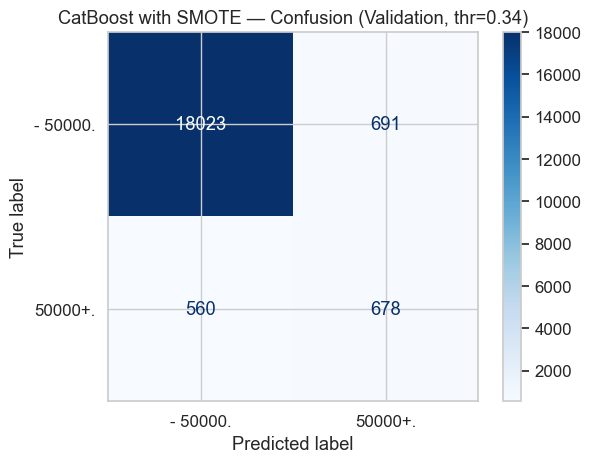



=== CatBoost with SMOTE — Test (thr=0.34) ===

              precision    recall  f1-score   support

           0     0.9697    0.9623    0.9660     18715
           1     0.4891    0.5452    0.5157      1238

    accuracy                         0.9365     19953
   macro avg     0.7294    0.7538    0.7408     19953
weighted avg     0.9399    0.9365    0.9381     19953

ROC-AUC (test): 0.9236


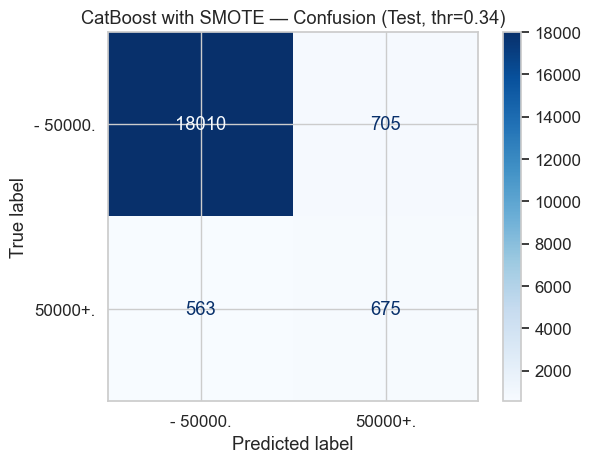


Top 15 features (CatBoost with SMOTE):


,Feature,Importance
163,education,15.554035
0,age,15.316637
112,detailed household and family stat_Householder,3.364778
125,num persons worked for employer_6,3.182311
79,sex_Male,2.665599
51,major occupation code_Executive admin and mana...,2.249928
154,own business or self employed_0,2.130011
5,weeks worked in year,2.083777
99,tax filer stat_Joint both under 65,2.077224
68,race_White,2.036672


,Model,Threshold,Val_F1,Test_F1,Val_ROC_AUC,Test_ROC_AUC,Val_Recall,Test_Recall,Val_Precision,Test_Precision
0,RandomForest + SMOTE,0.367975,0.535828,0.503020,0.931216,0.923711,0.613086,0.571890,0.475862,0.448954
1,XGBoost + SMOTE,0.678014,0.542481,0.524138,0.934374,0.927480,0.616317,0.583199,0.484444,0.475939
2,LightGBM + SMOTE,0.278373,0.525488,0.514576,0.933480,0.924900,0.620355,0.613086,0.455786,0.443341
3,CatBoost + SMOTE,0.336850,0.520138,0.515661,0.929557,0.923577,0.547658,0.545234,0.495252,0.489130


In [52]:
# === CatBoost (SMOTE + RS/GS + Threshold tuning) ===
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) Ensure model_results exists
try:
    model_results
except NameError:
    model_results = pd.DataFrame(columns=[
        "Model","Threshold","Val_F1","Test_F1","Val_ROC_AUC","Test_ROC_AUC",
        "Val_Recall","Test_Recall","Val_Precision","Test_Precision"
    ])

# 1) SMOTE: training only
print("Before SMOTE:")
print(f"Train - Class 0: {sum(y_train_df==0)}, Class 1: {sum(y_train_df==1)}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_df, y_train_df)
print("\nAfter SMOTE:")
print(f"Train - Class 0: {sum(y_train_resampled==0)}, Class 1: {sum(y_train_resampled==1)}")
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_df.columns)

# 2) Baseline CatBoost (quiet)
cb_base = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    subsample=0.9,
    random_seed=42,
    verbose=False,
    thread_count=-1
)
cb_base.fit(X_train_resampled, y_train_resampled)
y_val_proba_base = cb_base.predict_proba(X_val_df)[:, 1]
y_val_pred_base  = (y_val_proba_base >= 0.5).astype(int)

print("\n" + "="*60)
print("\n=== CatBoost with SMOTE — Baseline (Validation) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred_base, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba_base), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred_base),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title("CatBoost with SMOTE Baseline — Confusion (Validation)")
plt.show()
print("\n" + "="*60)

# 3) RandomizedSearchCV (small)
cv_rand = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cb = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC", random_seed=42, verbose=False, thread_count=-1)

param_dist = {
    "iterations": [500, 800, 1000],
    "learning_rate": [0.03, 0.05, 0.08],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1.0, 3.0, 5.0],
    "subsample": [0.8, 1.0]
}

cb_rs = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=cv_rand,
    n_jobs=1,   # safer on macOS; set to -1 if fine
    random_state=42,
    verbose=1
)
cb_rs.fit(X_train_resampled, y_train_resampled)
print("\nRS best params:", cb_rs.best_params_, " | best F1 (cv):", round(cb_rs.best_score_, 4))

# 4) GridSearchCV (tiny around RS best)
bp = cb_rs.best_params_
cb_gs = GridSearchCV(
    estimator=CatBoostClassifier(loss_function="Logloss", eval_metric="AUC", random_seed=42, verbose=False, thread_count=-1),
    param_grid={
        "iterations": sorted({max(300, bp["iterations"]-300), bp["iterations"], bp["iterations"]+300}),
        "learning_rate": sorted({max(0.02, bp["learning_rate"]/2), bp["learning_rate"], min(0.2, bp["learning_rate"]*1.5)}),
        "depth": sorted({max(4, bp["depth"]-2), bp["depth"], min(10, bp["depth"]+2)})
    },
    scoring="f1",
    cv=cv_rand,
    n_jobs=1,
    verbose=1
)
cb_gs.fit(X_train_resampled, y_train_resampled)
best_cb = cb_gs.best_estimator_
print("Grid best params:", cb_gs.best_params_, " | best F1 (cv):", round(cb_gs.best_score_, 4))

# 5) Threshold tuning (by F1) on validation
def pick_best_threshold_by_f1(y_true, y_proba, pos_label=1):
    prec, rec, thr = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    f1_vals = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
    best_idx = np.argmax(f1_vals)
    return float(thr[best_idx]), prec, rec, thr

y_val_proba = best_cb.predict_proba(X_val_df)[:, 1]
best_thresh, prec, rec, thr = pick_best_threshold_by_f1(y_val_df, y_val_proba, pos_label=1)
print(f"\n=== Optimal Threshold (CatBoost): {best_thresh:.3f} ===")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(thr, prec[:-1], label="Precision", linewidth=2)
plt.plot(thr, rec[:-1],  label="Recall", linewidth=2)
plt.axvline(best_thresh, ls="--", label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("CatBoost with SMOTE — Precision/Recall vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
f1_curve = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
plt.plot(thr, f1_curve, linewidth=2)
plt.axvline(best_thresh, ls="--", label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 Score vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 6) Validation evaluation
y_val_pred = (y_val_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== CatBoost with SMOTE — Validation (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"CatBoost with SMOTE — Confusion (Validation, thr={best_thresh:.2f})")
plt.show()

# 7) Test evaluation
y_test_proba = best_cb.predict_proba(X_test_df)[:, 1]
y_test_pred  = (y_test_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== CatBoost with SMOTE — Test (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_test_df, y_test_pred, digits=4))
print("ROC-AUC (test):", round(roc_auc_score(y_test_df, y_test_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_test_df, y_test_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"CatBoost with SMOTE — Confusion (Test, thr={best_thresh:.2f})")
plt.show()

# 8) Feature importance
imp_vals = best_cb.get_feature_importance()
imp_df = pd.DataFrame({"Feature": X_train_resampled.columns, "Importance": imp_vals}) \
         .sort_values("Importance", ascending=False)
print("\nTop 15 features (CatBoost with SMOTE):"); display(imp_df.head(15))

# 9) Append to results table
val_rep  = classification_report(y_val_df,  y_val_pred,  output_dict=True)
test_rep = classification_report(y_test_df, y_test_pred, output_dict=True)

cb_row = pd.DataFrame([{
    "Model":"CatBoost + SMOTE",
    "Threshold":best_thresh,
    "Val_F1":val_rep["1"]["f1-score"],
    "Test_F1":test_rep["1"]["f1-score"],
    "Val_ROC_AUC":roc_auc_score(y_val_df, y_val_proba),
    "Test_ROC_AUC":roc_auc_score(y_test_df, y_test_proba),
    "Val_Recall":val_rep["1"]["recall"],
    "Test_Recall":test_rep["1"]["recall"],
    "Val_Precision":val_rep["1"]["precision"],
    "Test_Precision":test_rep["1"]["precision"]
}])

model_results = pd.concat([model_results, cb_row], ignore_index=True)
display(model_results)


#### Logistic Regression

Before SMOTE:
Train - Class 0: 149712, Class 1: 9906

After SMOTE:
Train - Class 0: 149712, Class 1: 149712


=== Logistic Regression + SMOTE — Baseline (Validation) ===

              precision    recall  f1-score   support

           0     0.9911    0.8377    0.9080     18714
           1     0.2654    0.8861    0.4084      1238

    accuracy                         0.8407     19952
   macro avg     0.6282    0.8619    0.6582     19952
weighted avg     0.9461    0.8407    0.8770     19952

ROC-AUC (val): 0.9355


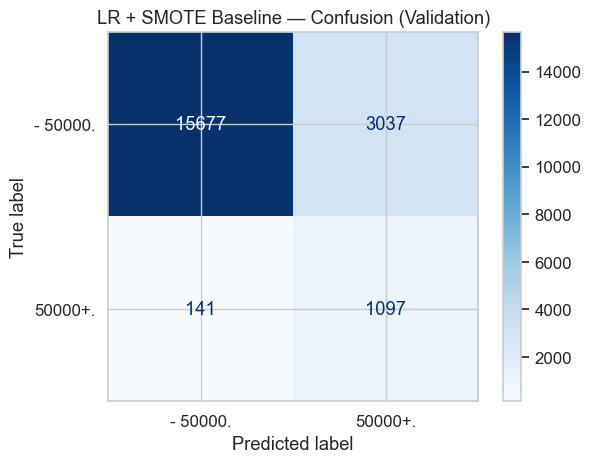


Fitting 2 folds for each of 12 candidates, totalling 24 fits

RS best params: {'C': np.float64(29.763514416313193)}  | best F1 (cv): 0.8737
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Grid best params: {'C': np.float64(29.763514416313193)}  | best F1 (cv): 0.8737

=== Optimal Threshold (LR): 0.871 ===


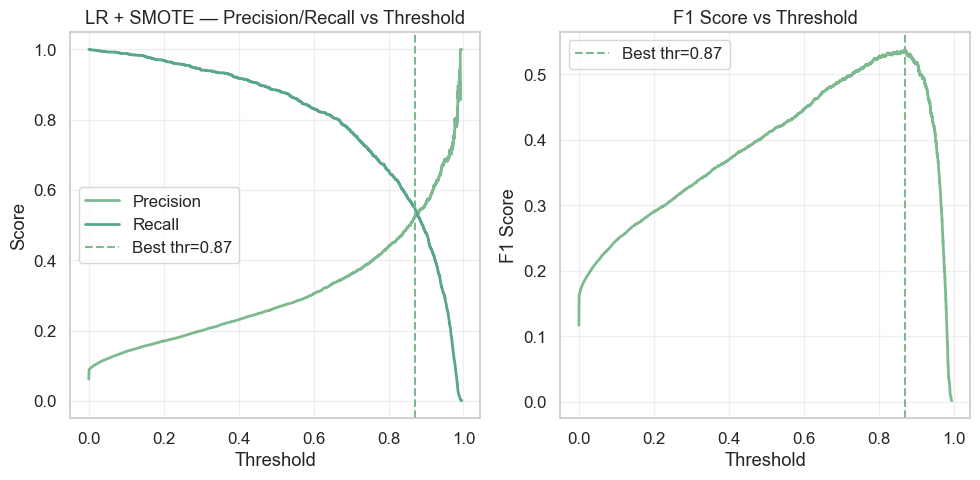



=== Logistic Regression + SMOTE — Validation (thr=0.87) ===

              precision    recall  f1-score   support

           0     0.9701    0.9674    0.9687     18714
           1     0.5267    0.5493    0.5378      1238

    accuracy                         0.9414     19952
   macro avg     0.7484    0.7583    0.7532     19952
weighted avg     0.9426    0.9414    0.9420     19952

ROC-AUC (val): 0.9353


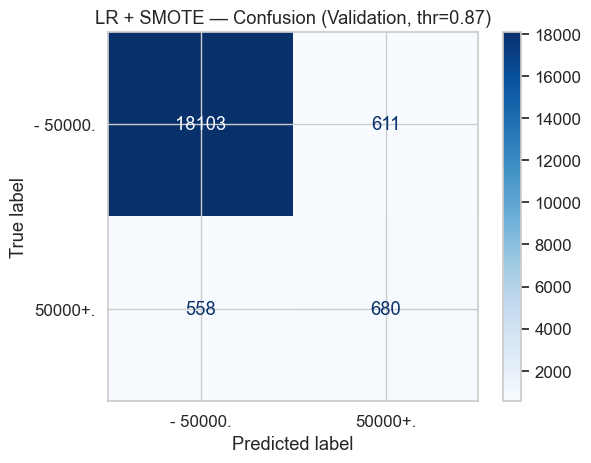



=== Logistic Regression + SMOTE — Test (thr=0.87) ===

              precision    recall  f1-score   support

           0     0.9684    0.9668    0.9676     18715
           1     0.5099    0.5226    0.5162      1238

    accuracy                         0.9392     19953
   macro avg     0.7391    0.7447    0.7419     19953
weighted avg     0.9399    0.9392    0.9396     19953

ROC-AUC (test): 0.9312


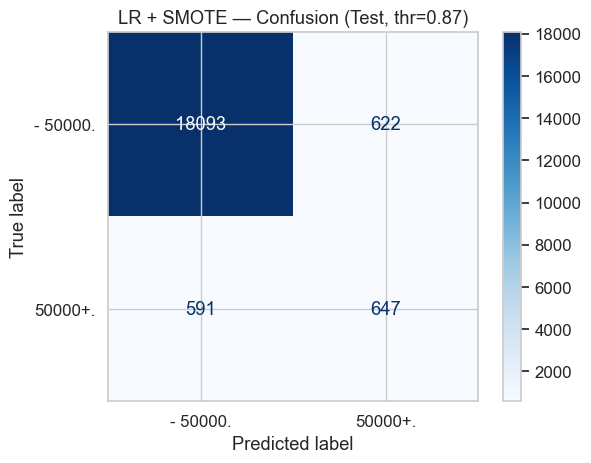


Top 15 features by |coef| (LR + SMOTE):


,Feature,Coef,Abs_Coef,Direction
111,detailed household and family stat_Group Quarters,-3.158927,3.158927,↓ (decreases odds of class 1)
5,weeks worked in year,2.468746,2.468746,↑ (increases odds of class 1)
101,tax filer stat_Nonfiler,-2.450285,2.450285,↓ (decreases odds of class 1)
14,class of worker_Without pay,-2.089667,2.089667,↓ (decreases odds of class 1)
58,major occupation code_Private household services,-1.756182,1.756182,↓ (decreases odds of class 1)
45,major industry code_Social services,-1.445326,1.445326,↓ (decreases odds of class 1)
0,age,1.438287,1.438287,↑ (increases odds of class 1)
128,family members under 18_Mother only present,-1.410467,1.410467,↓ (decreases odds of class 1)
19,marital stat_Married-A F spouse present,-1.368562,1.368562,↓ (decreases odds of class 1)
89,full or part time employment stat_Children or ...,-1.276988,1.276988,↓ (decreases odds of class 1)


,Model,Threshold,Val_F1,Test_F1,Val_ROC_AUC,Test_ROC_AUC,Val_Recall,Test_Recall,Val_Precision,Test_Precision
0,RandomForest + SMOTE,0.367975,0.535828,0.503020,0.931216,0.923711,0.613086,0.571890,0.475862,0.448954
1,XGBoost + SMOTE,0.678014,0.542481,0.524138,0.934374,0.927480,0.616317,0.583199,0.484444,0.475939
2,LightGBM + SMOTE,0.278373,0.525488,0.514576,0.933480,0.924900,0.620355,0.613086,0.455786,0.443341
3,CatBoost + SMOTE,0.336850,0.520138,0.515661,0.929557,0.923577,0.547658,0.545234,0.495252,0.489130
4,LogisticRegression + SMOTE,0.870531,0.537762,0.516155,0.935344,0.931172,0.549273,0.522617,0.526723,0.509850


In [53]:
# === Logistic Regression (SMOTE + RS/GS + Threshold tuning) ===
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.exceptions import ConvergenceWarning
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) Ensure model_results exists
try:
    model_results
except NameError:
    model_results = pd.DataFrame(columns=[
        "Model","Threshold","Val_F1","Test_F1","Val_ROC_AUC","Test_ROC_AUC",
        "Val_Recall","Test_Recall","Val_Precision","Test_Precision"
    ])

# NOTE: Logistic Regression is sensitive to feature scaling.
# Assuming your X_* are already encoded/scaled by your preprocessing pipeline.
# If NOT, wrap the estimator in a Pipeline(StandardScaler() -> LogisticRegression).

# 1) SMOTE: training only
print("Before SMOTE:")
print(f"Train - Class 0: {sum(y_train_df==0)}, Class 1: {sum(y_train_df==1)}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_df, y_train_df)
print("\nAfter SMOTE:")
print(f"Train - Class 0: {sum(y_train_resampled==0)}, Class 1: {sum(y_train_resampled==1)}")

# 2) Baseline LR (quick, strong max_iter to avoid warnings)
lr_base = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",      # robust for high-dim/sparse; supports proba
    max_iter=5000,
    class_weight=None,       # SMOTE already balances
    random_state=42
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lr_base.fit(X_train_resampled, y_train_resampled)

y_val_proba_base = lr_base.predict_proba(X_val_df)[:, 1]
y_val_pred_base  = (y_val_proba_base >= 0.5).astype(int)

print("\n" + "="*60)
print("\n=== Logistic Regression + SMOTE — Baseline (Validation) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred_base, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba_base), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred_base),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title("LR + SMOTE Baseline — Confusion (Validation)")
plt.show()
print("\n" + "="*60)

# 3) RandomizedSearchCV (small)
cv_rand = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
lr = LogisticRegression(
    penalty="l2",
    solver="liblinear",   # try 'saga' if you want elasticnet; keep liblinear for stability
    max_iter=5000,
    class_weight=None,
    random_state=42
)
param_dist = {
    "C": np.logspace(-3, 2, 20)  # 0.001 ... 100
    # If you want to also try solver: {"solver": ["liblinear","lbfgs"], "C": ...}
}

lr_rs = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=12,
    scoring="f1",
    cv=cv_rand,
    n_jobs=1,        # avoids macOS mp noise; use -1 if fine for you
    random_state=42,
    verbose=1
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lr_rs.fit(X_train_resampled, y_train_resampled)
print("\nRS best params:", lr_rs.best_params_, " | best F1 (cv):", round(lr_rs.best_score_, 4))

# 4) GridSearchCV (tiny around RS best)
bp = lr_rs.best_params_
grid_C = sorted({bp["C"]/3, bp["C"], bp["C"]*3})
lr_gs = GridSearchCV(
    estimator=LogisticRegression(penalty="l2", solver="liblinear",
                                 max_iter=5000, class_weight=None, random_state=42),
    param_grid={"C": grid_C},
    scoring="f1",
    cv=cv_rand,
    n_jobs=1,
    verbose=1
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lr_gs.fit(X_train_resampled, y_train_resampled)
best_lr = lr_gs.best_estimator_
print("Grid best params:", lr_gs.best_params_, " | best F1 (cv):", round(lr_gs.best_score_, 4))

# 5) Threshold tuning (by F1) on validation
def pick_best_threshold_by_f1(y_true, y_proba, pos_label=1):
    prec, rec, thr = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    f1_vals = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
    best_idx = np.argmax(f1_vals)
    return float(thr[best_idx]), prec, rec, thr

y_val_proba = best_lr.predict_proba(X_val_df)[:, 1]
best_thresh, prec, rec, thr = pick_best_threshold_by_f1(y_val_df, y_val_proba, pos_label=1)
print(f"\n=== Optimal Threshold (LR): {best_thresh:.3f} ===")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(thr, prec[:-1], label="Precision", linewidth=2)
plt.plot(thr, rec[:-1],  label="Recall", linewidth=2)
plt.axvline(best_thresh, ls="--", label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("LR + SMOTE — Precision/Recall vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
f1_curve = (2 * prec[:-1] * rec[:-1]) / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
plt.plot(thr, f1_curve, linewidth=2)
plt.axvline(best_thresh, ls="--", label=f"Best thr={best_thresh:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score"); plt.title("F1 Score vs Threshold")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 6) Validation evaluation
y_val_pred = (y_val_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== Logistic Regression + SMOTE — Validation (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_val_df, y_val_pred, digits=4))
print("ROC-AUC (val):", round(roc_auc_score(y_val_df, y_val_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_val_df, y_val_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"LR + SMOTE — Confusion (Validation, thr={best_thresh:.2f})")
plt.show()

# 7) Test evaluation
y_test_proba = best_lr.predict_proba(X_test_df)[:, 1]
y_test_pred  = (y_test_proba >= best_thresh).astype(int)
print("\n" + "="*60)
print(f"\n=== Logistic Regression + SMOTE — Test (thr={best_thresh:.2f}) ===")
print("\n" + "="*60)
print(classification_report(y_test_df, y_test_pred, digits=4))
print("ROC-AUC (test):", round(roc_auc_score(y_test_df, y_test_proba), 4))
ConfusionMatrixDisplay(confusion_matrix(y_test_df, y_test_pred),
                       display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title(f"LR + SMOTE — Confusion (Test, thr={best_thresh:.2f})")
plt.show()

# 8) "Feature importance" via coefficients
coef = best_lr.coef_.ravel()
imp_df = pd.DataFrame({
    "Feature": X_train_df.columns,
    "Coef": coef,
    "Abs_Coef": np.abs(coef),
    "Direction": np.where(coef >= 0, "↑ (increases odds of class 1)", "↓ (decreases odds of class 1)")
}).sort_values("Abs_Coef", ascending=False)
print("\nTop 15 features by |coef| (LR + SMOTE):"); display(imp_df.head(15))

# 9) Append to results table
val_rep  = classification_report(y_val_df,  y_val_pred,  output_dict=True)
test_rep = classification_report(y_test_df, y_test_pred, output_dict=True)

lr_row = pd.DataFrame([{
    "Model":"LogisticRegression + SMOTE",
    "Threshold":best_thresh,
    "Val_F1":val_rep["1"]["f1-score"],
    "Test_F1":test_rep["1"]["f1-score"],
    "Val_ROC_AUC":roc_auc_score(y_val_df, y_val_proba),
    "Test_ROC_AUC":roc_auc_score(y_test_df, y_test_proba),
    "Val_Recall":val_rep["1"]["recall"],
    "Test_Recall":test_rep["1"]["recall"],
    "Val_Precision":val_rep["1"]["precision"],
    "Test_Precision":test_rep["1"]["precision"]
}])

model_results = pd.concat([model_results, lr_row], ignore_index=True)
display(model_results)

### Model Performance Interpretation

The results summarize the effect of threshold tuning across all models, with a special focus on the minority class, since that’s where classification models tend to struggle.
The main objective here was to strike a balance between precision and recall, making **F1-score** the key evaluation metric.

#### Model-Wise Analysis
##### 1. Random Forest Classifier
- Threshold tuning drastically improved recall, helping the model catch ~201 more minority cases
- Huge recall jump (0.45→0.61) shows better detection of minority class
- Best for recall-oriented applications (e.g., fraud, risk detection)

##### 2. XGBoost Classifier
- Most stable model
- Minimal variance from baseline → threshold tuning has marginal gains.

##### 3. LightGBM
- Strong recall gain (0.48→0.62), precision dropped only slightly.
- Excellent recall without massive trade-offs — best “recall–precision balance.”

##### 4. CatBoost
- Reliable, but doesn’t outperform LightGBM or XGB significantly.
- Often excels on categorical-heavy data, so minor tuning might unlock more.

##### Logistic Regression
- Initially overpredicting minority (recall=0.88) → too many false positives (precision=0.26).
    - Threshold tuning fixed that, yielding balanced precision=recall≈0.52 and F1≈0.53.
 
#### Feature Importance Summary

- Education, age, and work intensity (weeks worked per year) are the dominant drivers of classification.
- Household roles and filing behavior distinguish independent earners from dependents.
- Gender and occupation variables introduce smaller but consistent effects.

- Tree-based methods have education + age + work as the most reliable predictors
- Logistic Regression clarifies the direction of influence, revealing that economic inactivity, dependency, or lack of formal employment strongly decreases the odds of belonging to the minority class.

### Future Scope

1. **Model enhancement:**
- Future iterations can experiment with advanced ensemble methods such as stacking or blending, combining models like LightGBM, XGBoost, and Logistic Regression to leverage their complementary strengths.
- Fine-tuning hyperparameters through Bayesian or Optuna-based optimization can also help push performance beyond current levels.

2. **Feature engineering and representation:**
Developing more informative features through interaction terms, non-linear transformations, or PCA-based dimensionality reduction could help the model uncover deeper socio-economic patterns that aren’t directly captured by raw categorical splits.

3. **Class imbalance handling:**
Beyond SMOTE, using other methods can improve minority-class recall while maintaining precision.

4. **Model explainability and stability:**
Incorporating SHAP or LIME visualizations will help interpret feature-level contributions and validate the consistency of key predictors like education, age, and work intensity across folds and models.